In [31]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.normal import Normal
import torch.nn.functional as F
import gc
import imutils
import math

import data
import models
from models import *

In [32]:
device = "cuda:2"
LATENT_DIM = 64
NUM_GENERATORS = 3
ALPHA = 3

In [33]:
# We will work with the distilled data for the sake of simplicity of our work, it turns out that the distilled dataset contains only 0s and 1s

In [34]:
X_train, X_test, Y_train, Y_test = data.get_dataset_augmented()

train_dataset = TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_dataset,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset = TensorDataset(X_test,Y_test)
test_dataloader = DataLoader(test_dataset,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

model_VAE = torch.load("../symmetry_2/VAE.pt")
model_VAE = model_VAE.to(device)

In [35]:
model_VAE.eval()
train_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_train.to(device)))).cpu().detach()
test_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_test.to(device)))).cpu().detach()

train_dataset_Z = TensorDataset(train_Z,Y_train)
train_dataloader_Z = DataLoader(train_dataset_Z,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset_Z = TensorDataset(test_Z,Y_test)
test_dataloader_Z = DataLoader(test_dataset_Z,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

In [36]:
model_fe = models.MLP(feature_size=LATENT_DIM).to(device)
model_fd = models.MLP(feature_size=LATENT_DIM).to(device)
# model_fo = models.LatentOracle().to(device)
model_fo = models.LatentOracle().to(device) # Since we ony have two elements

model_symmetry = models.GroupLatent(num_features=LATENT_DIM,num_generators=NUM_GENERATORS).to(device)

optimiser_fe = torch.optim.Adam(model_fe.parameters(), lr = 1e-3)
optimiser_fd = torch.optim.Adam(model_fd.parameters(), lr = 1e-3)
optimiser_fo = torch.optim.Adam(model_fo.parameters(), lr = 1e-3)
optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr = 1e-3)


criterion_mse = nn.MSELoss()
criterion_BCE = nn.BCEWithLogitsLoss()
criterion_entropy = nn.CrossEntropyLoss(reduction = 'none')

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [40]:
loss_S_closure = []
loss_S_orth = []
loss_S_collapse = []

loss_space = []
loss_oracle = []
for i in range(300):
    
    loss_S_closure_ = 0
    loss_S_orth_ = 0
    loss_S_collapse_ = 0

    loss_space_ = 0
    loss_oracle_ = 0
    
    for Z,M in tqdm(train_dataloader_Z):
        Z = Z.to(device)
        M = M.type(torch.LongTensor).to(device)
        
        optimiser_fd.zero_grad()
        optimiser_fe.zero_grad()
        optimiser_fo.zero_grad()
        optimiser_symmetry.zero_grad()

        theta = [(2*torch.rand(Z.shape[0],device = device) - 1) for i in range(NUM_GENERATORS)]  #Sampling

        P = model_fe(Z)
        P_S = model_symmetry(theta = theta, x = P)
        Z_S = model_fd(P_S)
        m = model_fo(Z)
        m_S = model_fo(Z_S)
        Z_P = model_fd(P)

        loss1 = criterion_entropy(m_S,torch.argmax(torch.softmax(m,-1), -1))
        loss2 = model_symmetry.orthogonal_loss()
        loss3 = model_symmetry.collapse_loss()
        loss5 = criterion_mse(Z,Z_P)
        loss6 = criterion_entropy(m.squeeze(),M)
        
        loss_S = torch.mean(loss1*torch.exp(-ALPHA*loss6)) + loss2 + loss3
        loss_Ae = loss5 # loss1 is not added since it is adjusted in the grad calculations
        loss_O = torch.mean(loss6)
        
        loss_S.backward(retain_graph=True)
        optimiser_symmetry.step()
        loss_Ae.backward(retain_graph=True)
        optimiser_fd.step() 
        optimiser_fe.step()
        optimiser_fo.zero_grad()
        loss_O.backward(retain_graph=True)
        optimiser_fo.step()
    
        
        loss_S_closure_ += torch.mean(loss1*torch.exp(-ALPHA*loss6)).item()
        try:
            loss_S_orth_ += loss2.item()
        except AttributeError:
            loss_S_orth_ = 0

        loss_S_collapse_ += loss3.item()

        loss_space_ += loss5.item()
        loss_oracle_ += loss_O.item()
    
    loss_S_closure_ /= len(train_dataloader)
    loss_S_orth_ /= len(train_dataloader)
    loss_S_collapse_ /= len(train_dataloader)

    loss_space_ /= len(train_dataloader)
    loss_oracle_ /= len(train_dataloader)
    
    
    loss_S_closure.append(loss_S_closure_)
    loss_S_collapse.append(loss_S_collapse_)
    loss_S_orth.append(loss_S_orth_)
    
    loss_space.append(loss_space_)
    loss_oracle.append(loss_oracle_)
    
    print(f"EPOCH {i} complete")
    print("=====================")
    print("Symmetry Closure Loss ",loss_S_closure_)
    print("Symmetry Orthogonality Loss ",loss_S_orth_)
    print("Symmetry Collapse Loss ",loss_S_collapse_)
    
    print("Space Inversion Loss ",loss_space_)
    print("Oracle loss",loss_oracle_)
    print("=====================")
    

100%|██████████| 166/166 [00:03<00:00, 51.72it/s]


EPOCH 0 complete
Symmetry Closure Loss  0.01691551263870514
Symmetry Orthogonality Loss  0.01642819414902703
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.1480499625076955
Oracle loss 1.7900903849716645


100%|██████████| 166/166 [00:03<00:00, 51.61it/s]


EPOCH 1 complete
Symmetry Closure Loss  0.02474169972835176
Symmetry Orthogonality Loss  0.005898283539250134
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022982425857279226
Oracle loss 1.4498755156275738


100%|██████████| 166/166 [00:03<00:00, 51.36it/s]


EPOCH 2 complete
Symmetry Closure Loss  0.027825119725641716
Symmetry Orthogonality Loss  0.005806957786700812
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015429439126929067
Oracle loss 1.2695711025272507


100%|██████████| 166/166 [00:03<00:00, 49.39it/s]


EPOCH 3 complete
Symmetry Closure Loss  0.03281951574496476
Symmetry Orthogonality Loss  0.005559327625052397
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015068487144995436
Oracle loss 1.1345988971641265


100%|██████████| 166/166 [00:03<00:00, 52.26it/s]


EPOCH 4 complete
Symmetry Closure Loss  0.03561297000711223
Symmetry Orthogonality Loss  0.005706756695521524
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0018595811225058712
Oracle loss 1.0409311106406063


100%|██████████| 166/166 [00:03<00:00, 49.76it/s]


EPOCH 5 complete
Symmetry Closure Loss  0.03619088322283274
Symmetry Orthogonality Loss  0.005797736287812691
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023802731940747203
Oracle loss 0.9724304112325232


100%|██████████| 166/166 [00:03<00:00, 52.24it/s]


EPOCH 6 complete
Symmetry Closure Loss  0.03497890602931919
Symmetry Orthogonality Loss  0.005798573852572815
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002707354800147285
Oracle loss 0.9210255242973925


100%|██████████| 166/166 [00:03<00:00, 51.66it/s]


EPOCH 7 complete
Symmetry Closure Loss  0.03356475836361747
Symmetry Orthogonality Loss  0.005683821468917002
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028283818462212762
Oracle loss 0.8781816388469145


100%|██████████| 166/166 [00:03<00:00, 50.10it/s]


EPOCH 8 complete
Symmetry Closure Loss  0.031667210307555746
Symmetry Orthogonality Loss  0.005612493896610047
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0024415518140352994
Oracle loss 0.8442975936165775


100%|██████████| 166/166 [00:03<00:00, 52.51it/s]


EPOCH 9 complete
Symmetry Closure Loss  0.03048872735620622
Symmetry Orthogonality Loss  0.005473878243040428
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00222576082212828
Oracle loss 0.8210901657500899


100%|██████████| 166/166 [00:03<00:00, 51.64it/s]


EPOCH 10 complete
Symmetry Closure Loss  0.0294569375060768
Symmetry Orthogonality Loss  0.005417105478111161
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002297785716602601
Oracle loss 0.8048975449728678


100%|██████████| 166/166 [00:03<00:00, 50.55it/s]


EPOCH 11 complete
Symmetry Closure Loss  0.02855218696710934
Symmetry Orthogonality Loss  0.005372131386412734
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002284919147390917
Oracle loss 0.7930472503943615


100%|██████████| 166/166 [00:03<00:00, 51.95it/s]


EPOCH 12 complete
Symmetry Closure Loss  0.027875172972948437
Symmetry Orthogonality Loss  0.005440723308059107
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002246281181192811
Oracle loss 0.7842018457062273


100%|██████████| 166/166 [00:03<00:00, 51.37it/s]


EPOCH 13 complete
Symmetry Closure Loss  0.027256263947361206
Symmetry Orthogonality Loss  0.0054989212517996865
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002178294764388442
Oracle loss 0.77717834028853


100%|██████████| 166/166 [00:03<00:00, 50.40it/s]


EPOCH 14 complete
Symmetry Closure Loss  0.026619449078318584
Symmetry Orthogonality Loss  0.0053126396112009346
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002107341306042824
Oracle loss 0.7717338513178997


100%|██████████| 166/166 [00:03<00:00, 51.65it/s]


EPOCH 15 complete
Symmetry Closure Loss  0.02608622509582215
Symmetry Orthogonality Loss  0.005376412123666111
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002045049651873758
Oracle loss 0.7674357959304947


100%|██████████| 166/166 [00:03<00:00, 51.60it/s]


EPOCH 16 complete
Symmetry Closure Loss  0.025593555521175086
Symmetry Orthogonality Loss  0.005272572731083057
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002027882918777191
Oracle loss 0.7638157871832331


100%|██████████| 166/166 [00:03<00:00, 50.62it/s]


EPOCH 17 complete
Symmetry Closure Loss  0.02501088610839054
Symmetry Orthogonality Loss  0.005160533845514418
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0019345185235535435
Oracle loss 0.7608461444636425


100%|██████████| 166/166 [00:03<00:00, 51.40it/s]


EPOCH 18 complete
Symmetry Closure Loss  0.02463311335094363
Symmetry Orthogonality Loss  0.005261452660996871
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0018721739396856851
Oracle loss 0.7582541625183749


100%|██████████| 166/166 [00:03<00:00, 51.15it/s]


EPOCH 19 complete
Symmetry Closure Loss  0.024036262184381485
Symmetry Orthogonality Loss  0.005176767274872007
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0018720258432664875
Oracle loss 0.7561989649232611


100%|██████████| 166/166 [00:03<00:00, 51.44it/s]


EPOCH 20 complete
Symmetry Closure Loss  0.023554352785359663
Symmetry Orthogonality Loss  0.005189409221421523
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017774177817571684
Oracle loss 0.7543277568127735


100%|██████████| 166/166 [00:03<00:00, 48.23it/s]


EPOCH 21 complete
Symmetry Closure Loss  0.02309308217905731
Symmetry Orthogonality Loss  0.005087510870590088
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017014580473012056
Oracle loss 0.7530197953603354


100%|██████████| 166/166 [00:03<00:00, 52.89it/s]


EPOCH 22 complete
Symmetry Closure Loss  0.022812541192734098
Symmetry Orthogonality Loss  0.005090257164135754
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001651217759844948
Oracle loss 0.7514559084392456


100%|██████████| 166/166 [00:03<00:00, 52.98it/s]


EPOCH 23 complete
Symmetry Closure Loss  0.022543243199856167
Symmetry Orthogonality Loss  0.005118597590600152
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015548656081657362
Oracle loss 0.7500904001385332


100%|██████████| 166/166 [00:03<00:00, 52.10it/s]


EPOCH 24 complete
Symmetry Closure Loss  0.022189698642097324
Symmetry Orthogonality Loss  0.005077192318592086
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015119664702025882
Oracle loss 0.749254988977708


100%|██████████| 166/166 [00:03<00:00, 52.45it/s]


EPOCH 25 complete
Symmetry Closure Loss  0.0220093319910657
Symmetry Orthogonality Loss  0.004997476091024926
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014368493084694787
Oracle loss 0.7481321354946459


100%|██████████| 166/166 [00:03<00:00, 51.56it/s]


EPOCH 26 complete
Symmetry Closure Loss  0.021754627744386714
Symmetry Orthogonality Loss  0.0048702157871146875
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014185266182140772
Oracle loss 0.7473530762166862


100%|██████████| 166/166 [00:03<00:00, 49.67it/s]


EPOCH 27 complete
Symmetry Closure Loss  0.021507131968097514
Symmetry Orthogonality Loss  0.004834174018644963
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0013530629684206054
Oracle loss 0.7463482388530869


100%|██████████| 166/166 [00:03<00:00, 51.01it/s]


EPOCH 28 complete
Symmetry Closure Loss  0.02141148819172957
Symmetry Orthogonality Loss  0.004849446317495172
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0013369124113436204
Oracle loss 0.7453338511018868


100%|██████████| 166/166 [00:03<00:00, 51.41it/s]


EPOCH 29 complete
Symmetry Closure Loss  0.021309273743844896
Symmetry Orthogonality Loss  0.004833281076659101
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0013057430525848933
Oracle loss 0.7445871384747057


100%|██████████| 166/166 [00:03<00:00, 51.38it/s]


EPOCH 30 complete
Symmetry Closure Loss  0.021092448181596148
Symmetry Orthogonality Loss  0.00483874680407076
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012953250131749335
Oracle loss 0.7436096542570965


100%|██████████| 166/166 [00:03<00:00, 49.37it/s]


EPOCH 31 complete
Symmetry Closure Loss  0.021157051369278545
Symmetry Orthogonality Loss  0.004873180989153594
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012185870254614267
Oracle loss 0.7428499567939575


100%|██████████| 166/166 [00:03<00:00, 51.66it/s]


EPOCH 32 complete
Symmetry Closure Loss  0.021016145472874843
Symmetry Orthogonality Loss  0.004864414331940822
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012330753042878785
Oracle loss 0.7416183287838856


100%|██████████| 166/166 [00:03<00:00, 49.07it/s]


EPOCH 33 complete
Symmetry Closure Loss  0.02094215547374214
Symmetry Orthogonality Loss  0.0047271993791078585
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011931671613703918
Oracle loss 0.7403687414634659


100%|██████████| 166/166 [00:03<00:00, 51.31it/s]


EPOCH 34 complete
Symmetry Closure Loss  0.020897737311491048
Symmetry Orthogonality Loss  0.004652692692309439
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011877737341852612
Oracle loss 0.7391571223017681


100%|██████████| 166/166 [00:03<00:00, 52.64it/s]


EPOCH 35 complete
Symmetry Closure Loss  0.020919040170868475
Symmetry Orthogonality Loss  0.004791122659232961
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011818941222526223
Oracle loss 0.7375000571630087


100%|██████████| 166/166 [00:03<00:00, 53.07it/s]


EPOCH 36 complete
Symmetry Closure Loss  0.0208292063213436
Symmetry Orthogonality Loss  0.004712920922067869
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011814054244068865
Oracle loss 0.7357492102197853


100%|██████████| 166/166 [00:03<00:00, 47.21it/s]


EPOCH 37 complete
Symmetry Closure Loss  0.02081056733626917
Symmetry Orthogonality Loss  0.00463632234170225
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011605724070995417
Oracle loss 0.7338605943214462


100%|██████████| 166/166 [00:03<00:00, 52.03it/s]


EPOCH 38 complete
Symmetry Closure Loss  0.020636844863913144
Symmetry Orthogonality Loss  0.004663815309506762
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011675353484587318
Oracle loss 0.732093308345381


100%|██████████| 166/166 [00:03<00:00, 48.76it/s]


EPOCH 39 complete
Symmetry Closure Loss  0.020428677134395362
Symmetry Orthogonality Loss  0.004717193681365216
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011558518808121871
Oracle loss 0.7304127277380013


100%|██████████| 166/166 [00:03<00:00, 53.28it/s]


EPOCH 40 complete
Symmetry Closure Loss  0.020387446934200196
Symmetry Orthogonality Loss  0.004704158708273646
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011268093900093023
Oracle loss 0.7286399624433862


100%|██████████| 166/166 [00:03<00:00, 51.41it/s]


EPOCH 41 complete
Symmetry Closure Loss  0.02008338826876807
Symmetry Orthogonality Loss  0.004688647598117949
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011457006895146053
Oracle loss 0.7272376669458596


100%|██████████| 166/166 [00:03<00:00, 51.16it/s]


EPOCH 42 complete
Symmetry Closure Loss  0.01979532528174929
Symmetry Orthogonality Loss  0.004593504887321089
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011259358778107822
Oracle loss 0.7258499670459564


100%|██████████| 166/166 [00:03<00:00, 47.97it/s]


EPOCH 43 complete
Symmetry Closure Loss  0.019569866931492305
Symmetry Orthogonality Loss  0.004579537461163947
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011043403801194068
Oracle loss 0.7246025161570814


100%|██████████| 166/166 [00:03<00:00, 48.58it/s]


EPOCH 44 complete
Symmetry Closure Loss  0.01939565073474344
Symmetry Orthogonality Loss  0.004483914415138852
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010960691226982926
Oracle loss 0.7233291979295662


100%|██████████| 166/166 [00:03<00:00, 52.09it/s]


EPOCH 45 complete
Symmetry Closure Loss  0.019129560789070934
Symmetry Orthogonality Loss  0.004363238303753805
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010734571165725005
Oracle loss 0.7224599776497806


100%|██████████| 166/166 [00:03<00:00, 52.26it/s]


EPOCH 46 complete
Symmetry Closure Loss  0.01876017132616905
Symmetry Orthogonality Loss  0.004440507740736097
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010747514059907387
Oracle loss 0.721425542630345


100%|██████████| 166/166 [00:03<00:00, 53.02it/s]


EPOCH 47 complete
Symmetry Closure Loss  0.018529717664582182
Symmetry Orthogonality Loss  0.004453944875465998
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011168924947157054
Oracle loss 0.7208023764282824


100%|██████████| 166/166 [00:03<00:00, 50.72it/s]


EPOCH 48 complete
Symmetry Closure Loss  0.018303841969604235
Symmetry Orthogonality Loss  0.0043744414396786006
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010707346832587283
Oracle loss 0.7196953483374722


100%|██████████| 166/166 [00:03<00:00, 47.65it/s]


EPOCH 49 complete
Symmetry Closure Loss  0.01799409424729017
Symmetry Orthogonality Loss  0.004431264655922641
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010511611243962389
Oracle loss 0.7189053939767631


100%|██████████| 166/166 [00:03<00:00, 49.43it/s]


EPOCH 50 complete
Symmetry Closure Loss  0.017707745443625623
Symmetry Orthogonality Loss  0.004498124049684729
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009837985331198223
Oracle loss 0.7181015976940293


100%|██████████| 166/166 [00:03<00:00, 52.91it/s]


EPOCH 51 complete
Symmetry Closure Loss  0.01755932709538793
Symmetry Orthogonality Loss  0.004402924281354231
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010625321224488947
Oracle loss 0.7173810716134956


100%|██████████| 166/166 [00:03<00:00, 48.35it/s]


EPOCH 52 complete
Symmetry Closure Loss  0.0173099445717701
Symmetry Orthogonality Loss  0.004371991804632616
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00103202538181893
Oracle loss 0.7166015164679792


100%|██████████| 166/166 [00:03<00:00, 52.00it/s]


EPOCH 53 complete
Symmetry Closure Loss  0.017005584898393555
Symmetry Orthogonality Loss  0.004293895994189633
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001012955187730132
Oracle loss 0.7159051791013006


100%|██████████| 166/166 [00:03<00:00, 52.78it/s]


EPOCH 54 complete
Symmetry Closure Loss  0.016810771397662808
Symmetry Orthogonality Loss  0.0042297797030713185
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00100202353654362
Oracle loss 0.7150408101369099


100%|██████████| 166/166 [00:03<00:00, 46.79it/s]


EPOCH 55 complete
Symmetry Closure Loss  0.016553487320127618
Symmetry Orthogonality Loss  0.004245109741115965
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010017685897940074
Oracle loss 0.7142778810966446


100%|██████████| 166/166 [00:03<00:00, 46.67it/s]


EPOCH 56 complete
Symmetry Closure Loss  0.016385626895016575
Symmetry Orthogonality Loss  0.004226108627247972
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010009448139378465
Oracle loss 0.713571473776576


100%|██████████| 166/166 [00:03<00:00, 49.87it/s]


EPOCH 57 complete
Symmetry Closure Loss  0.01611355529447277
Symmetry Orthogonality Loss  0.004171635499729
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009617296966909241
Oracle loss 0.7125235756477678


100%|██████████| 166/166 [00:03<00:00, 49.50it/s]


EPOCH 58 complete
Symmetry Closure Loss  0.015949305842619343
Symmetry Orthogonality Loss  0.004021563978181277
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009864659300382551
Oracle loss 0.7117800044726177


100%|██████████| 166/166 [00:03<00:00, 49.40it/s]


EPOCH 59 complete
Symmetry Closure Loss  0.015759446439389365
Symmetry Orthogonality Loss  0.004065331495198679
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009440181584725807
Oracle loss 0.7107784543410841


100%|██████████| 166/166 [00:03<00:00, 51.52it/s]


EPOCH 60 complete
Symmetry Closure Loss  0.015541425367525542
Symmetry Orthogonality Loss  0.003996682420642261
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009340007813277105
Oracle loss 0.70964270183839


100%|██████████| 166/166 [00:03<00:00, 49.73it/s]


EPOCH 61 complete
Symmetry Closure Loss  0.01527137695306755
Symmetry Orthogonality Loss  0.004014984404398914
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000943504676786644
Oracle loss 0.7087182039956013


100%|██████████| 166/166 [00:03<00:00, 52.20it/s]


EPOCH 62 complete
Symmetry Closure Loss  0.015100725758147526
Symmetry Orthogonality Loss  0.004029305888822369
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009336793330268014
Oracle loss 0.7072096510105822


100%|██████████| 166/166 [00:03<00:00, 49.15it/s]


EPOCH 63 complete
Symmetry Closure Loss  0.01483348393476153
Symmetry Orthogonality Loss  0.004086190186642918
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009437474640961513
Oracle loss 0.7063436070120478


100%|██████████| 166/166 [00:03<00:00, 49.03it/s]


EPOCH 64 complete
Symmetry Closure Loss  0.014703519204743656
Symmetry Orthogonality Loss  0.004145306896934488
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009289851169528283
Oracle loss 0.7051382693181555


100%|██████████| 166/166 [00:03<00:00, 48.27it/s]


EPOCH 65 complete
Symmetry Closure Loss  0.01433890003217272
Symmetry Orthogonality Loss  0.0040704365216577085
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009004801675868053
Oracle loss 0.7041971963572214


100%|██████████| 166/166 [00:03<00:00, 52.05it/s]


EPOCH 66 complete
Symmetry Closure Loss  0.014100717375032514
Symmetry Orthogonality Loss  0.003924953160773828
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009307066527060626
Oracle loss 0.7034145651093449


100%|██████████| 166/166 [00:03<00:00, 50.03it/s]


EPOCH 67 complete
Symmetry Closure Loss  0.01388978334817003
Symmetry Orthogonality Loss  0.003935480779261294
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009007566932487829
Oracle loss 0.702490385038307


100%|██████████| 166/166 [00:03<00:00, 51.26it/s]


EPOCH 68 complete
Symmetry Closure Loss  0.013574249397245157
Symmetry Orthogonality Loss  0.004049621982477516
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008920892134746425
Oracle loss 0.7016518999295063


100%|██████████| 166/166 [00:03<00:00, 49.00it/s]


EPOCH 69 complete
Symmetry Closure Loss  0.013380507141890296
Symmetry Orthogonality Loss  0.003925800925199257
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008803437213576118
Oracle loss 0.7012399122657547


100%|██████████| 166/166 [00:03<00:00, 51.06it/s]


EPOCH 70 complete
Symmetry Closure Loss  0.013200412840997598
Symmetry Orthogonality Loss  0.003975388216673879
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009062183135138623
Oracle loss 0.7003172679119799


100%|██████████| 166/166 [00:03<00:00, 50.41it/s]


EPOCH 71 complete
Symmetry Closure Loss  0.013057534902704409
Symmetry Orthogonality Loss  0.0038511544137811624
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008348198817953108
Oracle loss 0.7000834737197462


100%|██████████| 166/166 [00:03<00:00, 52.32it/s]


EPOCH 72 complete
Symmetry Closure Loss  0.012851549497614783
Symmetry Orthogonality Loss  0.0038763075514348694
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000850204338743183
Oracle loss 0.6994934387235756


100%|██████████| 166/166 [00:03<00:00, 48.22it/s]


EPOCH 73 complete
Symmetry Closure Loss  0.012576477703110999
Symmetry Orthogonality Loss  0.0038449959899579367
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008443327293119741
Oracle loss 0.6988386831369745


100%|██████████| 166/166 [00:03<00:00, 51.70it/s]


EPOCH 74 complete
Symmetry Closure Loss  0.012466254666537405
Symmetry Orthogonality Loss  0.0037920283776404985
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008182607034322278
Oracle loss 0.6984790872378521


100%|██████████| 166/166 [00:03<00:00, 50.21it/s]


EPOCH 75 complete
Symmetry Closure Loss  0.012284716355603143
Symmetry Orthogonality Loss  0.0037658838990021004
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008335474767043334
Oracle loss 0.6980580166879907


100%|██████████| 166/166 [00:03<00:00, 52.85it/s]


EPOCH 76 complete
Symmetry Closure Loss  0.012077398065208312
Symmetry Orthogonality Loss  0.0038047103654503464
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008160877777880663
Oracle loss 0.697825100407543


100%|██████████| 166/166 [00:03<00:00, 50.91it/s]


EPOCH 77 complete
Symmetry Closure Loss  0.011988894149930361
Symmetry Orthogonality Loss  0.003780342708622296
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008190278516498854
Oracle loss 0.6972067176577557


100%|██████████| 166/166 [00:03<00:00, 51.50it/s]


EPOCH 78 complete
Symmetry Closure Loss  0.011821409816438535
Symmetry Orthogonality Loss  0.0036479739404945487
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007904945306075984
Oracle loss 0.6968098706509693


100%|██████████| 166/166 [00:03<00:00, 47.64it/s]


EPOCH 79 complete
Symmetry Closure Loss  0.011652734315763396
Symmetry Orthogonality Loss  0.0036512601711080374
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007888149818635534
Oracle loss 0.6965504238404423


100%|██████████| 166/166 [00:03<00:00, 50.60it/s]


EPOCH 80 complete
Symmetry Closure Loss  0.011592370951660427
Symmetry Orthogonality Loss  0.003597101310256824
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007616892135814281
Oracle loss 0.6962493220007563


100%|██████████| 166/166 [00:03<00:00, 48.60it/s]


EPOCH 81 complete
Symmetry Closure Loss  0.011396751200488532
Symmetry Orthogonality Loss  0.003549542024181819
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007788197664089546
Oracle loss 0.6959211312862764


100%|██████████| 166/166 [00:03<00:00, 48.72it/s]


EPOCH 82 complete
Symmetry Closure Loss  0.011380788269845477
Symmetry Orthogonality Loss  0.003627892429323261
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007437378335014794
Oracle loss 0.6957419651100435


100%|██████████| 166/166 [00:03<00:00, 51.35it/s]


EPOCH 83 complete
Symmetry Closure Loss  0.011132978520030716
Symmetry Orthogonality Loss  0.0037243928092655287
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007361361875440028
Oracle loss 0.6953210888138737


100%|██████████| 166/166 [00:03<00:00, 51.57it/s]


EPOCH 84 complete
Symmetry Closure Loss  0.011033494109624481
Symmetry Orthogonality Loss  0.0036277279204475774
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007194870359163327
Oracle loss 0.6951723741479667


100%|██████████| 166/166 [00:03<00:00, 50.48it/s]


EPOCH 85 complete
Symmetry Closure Loss  0.010965094727699656
Symmetry Orthogonality Loss  0.003571497259594231
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007380027119182499
Oracle loss 0.6951121120567781


100%|██████████| 166/166 [00:03<00:00, 46.56it/s]


EPOCH 86 complete
Symmetry Closure Loss  0.010764887500329908
Symmetry Orthogonality Loss  0.0036173994310693927
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006789568329863923
Oracle loss 0.6948203042329076


100%|██████████| 166/166 [00:03<00:00, 49.61it/s]


EPOCH 87 complete
Symmetry Closure Loss  0.010711104524916554
Symmetry Orthogonality Loss  0.0035106663799743696
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007197446882702321
Oracle loss 0.6945264149143036


100%|██████████| 166/166 [00:03<00:00, 50.86it/s]


EPOCH 88 complete
Symmetry Closure Loss  0.010606089012181184
Symmetry Orthogonality Loss  0.0034715061676295765
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006782609751274114
Oracle loss 0.6943425751594176


100%|██████████| 166/166 [00:03<00:00, 51.75it/s]


EPOCH 89 complete
Symmetry Closure Loss  0.010483683782618448
Symmetry Orthogonality Loss  0.0034287060535209903
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006944884392517024
Oracle loss 0.6941204825079584


100%|██████████| 166/166 [00:03<00:00, 51.43it/s]


EPOCH 90 complete
Symmetry Closure Loss  0.01040979149942118
Symmetry Orthogonality Loss  0.003353432156089469
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006844044451921595
Oracle loss 0.6938264922923353


100%|██████████| 166/166 [00:03<00:00, 49.02it/s]


EPOCH 91 complete
Symmetry Closure Loss  0.010290769641343728
Symmetry Orthogonality Loss  0.0034438712502751186
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006830891855874559
Oracle loss 0.6938659936548716


100%|██████████| 166/166 [00:03<00:00, 50.25it/s]


EPOCH 92 complete
Symmetry Closure Loss  0.01019492500226002
Symmetry Orthogonality Loss  0.003409152404483722
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006713750439062042
Oracle loss 0.6935235100338258


100%|██████████| 166/166 [00:03<00:00, 48.29it/s]


EPOCH 93 complete
Symmetry Closure Loss  0.010064449116408107
Symmetry Orthogonality Loss  0.0033490353205005625
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006616944243783603
Oracle loss 0.6934009172830237


100%|██████████| 166/166 [00:03<00:00, 51.21it/s]


EPOCH 94 complete
Symmetry Closure Loss  0.010002830638045287
Symmetry Orthogonality Loss  0.0033359061800369836
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006770760968260197
Oracle loss 0.6931248885321329


100%|██████████| 166/166 [00:03<00:00, 50.48it/s]


EPOCH 95 complete
Symmetry Closure Loss  0.010002054290913314
Symmetry Orthogonality Loss  0.0032436834867056235
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006359933338307563
Oracle loss 0.6932171619082071


100%|██████████| 166/166 [00:03<00:00, 51.38it/s]


EPOCH 96 complete
Symmetry Closure Loss  0.009806733236210534
Symmetry Orthogonality Loss  0.0032760243545881056
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000627322235714128
Oracle loss 0.6930990179619158


100%|██████████| 166/166 [00:03<00:00, 51.32it/s]


EPOCH 97 complete
Symmetry Closure Loss  0.009805116213364414
Symmetry Orthogonality Loss  0.0033402152763432765
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006529671279923901
Oracle loss 0.6928931208978216


100%|██████████| 166/166 [00:03<00:00, 49.66it/s]


EPOCH 98 complete
Symmetry Closure Loss  0.009847261510924044
Symmetry Orthogonality Loss  0.003292549015808267
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000654470759685185
Oracle loss 0.6927857355899122


100%|██████████| 166/166 [00:03<00:00, 48.26it/s]


EPOCH 99 complete
Symmetry Closure Loss  0.009688479461179799
Symmetry Orthogonality Loss  0.0032443802310041635
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006358949930395886
Oracle loss 0.6925374829625509


100%|██████████| 166/166 [00:03<00:00, 51.13it/s]


EPOCH 100 complete
Symmetry Closure Loss  0.009609326204083052
Symmetry Orthogonality Loss  0.003221759935897068
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006217822994958295
Oracle loss 0.6925756629691067


100%|██████████| 166/166 [00:03<00:00, 52.14it/s]


EPOCH 101 complete
Symmetry Closure Loss  0.009495421778410673
Symmetry Orthogonality Loss  0.003232416445782116
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006334936861313475
Oracle loss 0.6923741475645319


100%|██████████| 166/166 [00:03<00:00, 52.22it/s]


EPOCH 102 complete
Symmetry Closure Loss  0.009490072637437338
Symmetry Orthogonality Loss  0.0032610018128888256
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000614621069531955
Oracle loss 0.6923053210758301


100%|██████████| 166/166 [00:03<00:00, 52.40it/s]


EPOCH 103 complete
Symmetry Closure Loss  0.009447421368031976
Symmetry Orthogonality Loss  0.003258605486242078
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000604149970332587
Oracle loss 0.6921966294926333


100%|██████████| 166/166 [00:03<00:00, 51.12it/s]


EPOCH 104 complete
Symmetry Closure Loss  0.009352146182209253
Symmetry Orthogonality Loss  0.0031615073220377945
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006306050604781562
Oracle loss 0.6921082961272045


100%|██████████| 166/166 [00:03<00:00, 49.53it/s]


EPOCH 105 complete
Symmetry Closure Loss  0.00924708333472351
Symmetry Orthogonality Loss  0.003176168211825551
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005825126599043563
Oracle loss 0.6919943952416799


100%|██████████| 166/166 [00:03<00:00, 52.08it/s]


EPOCH 106 complete
Symmetry Closure Loss  0.00916852075494377
Symmetry Orthogonality Loss  0.003241661794382675
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006168381965309605
Oracle loss 0.6918559706354716


100%|██████████| 166/166 [00:03<00:00, 50.19it/s]


EPOCH 107 complete
Symmetry Closure Loss  0.00912877104346113
Symmetry Orthogonality Loss  0.0031741209544174104
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005796959840044581
Oracle loss 0.6919250046632376


100%|██████████| 166/166 [00:03<00:00, 50.32it/s]


EPOCH 108 complete
Symmetry Closure Loss  0.009082183710310653
Symmetry Orthogonality Loss  0.0031297834763999084
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006088759511336123
Oracle loss 0.691700228007443


100%|██████████| 166/166 [00:03<00:00, 48.34it/s]


EPOCH 109 complete
Symmetry Closure Loss  0.009063672423026109
Symmetry Orthogonality Loss  0.0031971172163128316
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006226954572477816
Oracle loss 0.6917887376733574


100%|██████████| 166/166 [00:03<00:00, 50.98it/s]


EPOCH 110 complete
Symmetry Closure Loss  0.008973348369619933
Symmetry Orthogonality Loss  0.0031679729883368297
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005938133282000648
Oracle loss 0.6915634497102484


100%|██████████| 166/166 [00:03<00:00, 48.67it/s]


EPOCH 111 complete
Symmetry Closure Loss  0.009014784969972918
Symmetry Orthogonality Loss  0.0031143099683931612
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006084493890892804
Oracle loss 0.6915943769805403


100%|██████████| 166/166 [00:03<00:00, 49.78it/s]


EPOCH 112 complete
Symmetry Closure Loss  0.008861608211377478
Symmetry Orthogonality Loss  0.003043977044388113
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005830268979392363
Oracle loss 0.6914943880345448


100%|██████████| 166/166 [00:03<00:00, 50.14it/s]


EPOCH 113 complete
Symmetry Closure Loss  0.008841482613864074
Symmetry Orthogonality Loss  0.0029637938356924668
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000583342459727449
Oracle loss 0.691404098128698


100%|██████████| 166/166 [00:03<00:00, 50.69it/s]


EPOCH 114 complete
Symmetry Closure Loss  0.008759891984602773
Symmetry Orthogonality Loss  0.0031227430017350846
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006013155826479645
Oracle loss 0.6913010097411741


100%|██████████| 166/166 [00:03<00:00, 49.99it/s]


EPOCH 115 complete
Symmetry Closure Loss  0.008662258064464093
Symmetry Orthogonality Loss  0.003065520319638841
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005522698666465592
Oracle loss 0.6911563165934689


100%|██████████| 166/166 [00:03<00:00, 51.02it/s]


EPOCH 116 complete
Symmetry Closure Loss  0.008650603678907794
Symmetry Orthogonality Loss  0.0030880349909841835
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005610646874256747
Oracle loss 0.6911086468811495


100%|██████████| 166/166 [00:03<00:00, 50.37it/s]


EPOCH 117 complete
Symmetry Closure Loss  0.008657523262572575
Symmetry Orthogonality Loss  0.002998233197750636
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005918186370434845
Oracle loss 0.6910239253417555


100%|██████████| 166/166 [00:03<00:00, 49.28it/s]


EPOCH 118 complete
Symmetry Closure Loss  0.008506594267842102
Symmetry Orthogonality Loss  0.0029181828231449767
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005567639549641522
Oracle loss 0.6910365500363959


100%|██████████| 166/166 [00:03<00:00, 49.53it/s]


EPOCH 119 complete
Symmetry Closure Loss  0.008474070587229118
Symmetry Orthogonality Loss  0.0029494792955130876
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005612867463208982
Oracle loss 0.6911018031189241


100%|██████████| 166/166 [00:03<00:00, 50.79it/s]


EPOCH 120 complete
Symmetry Closure Loss  0.008457306009459209
Symmetry Orthogonality Loss  0.003068300955704447
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005798703634617738
Oracle loss 0.6909801590155407


100%|██████████| 166/166 [00:03<00:00, 49.00it/s]


EPOCH 121 complete
Symmetry Closure Loss  0.008450242079210928
Symmetry Orthogonality Loss  0.0029658050436234796
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005816588737912117
Oracle loss 0.6907303419457861


100%|██████████| 166/166 [00:03<00:00, 47.96it/s]


EPOCH 122 complete
Symmetry Closure Loss  0.008357199542897653
Symmetry Orthogonality Loss  0.0029901534035599916
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005634715954186844
Oracle loss 0.6907827258110046


100%|██████████| 166/166 [00:03<00:00, 49.52it/s]


EPOCH 123 complete
Symmetry Closure Loss  0.008341099337551248
Symmetry Orthogonality Loss  0.0029952804465407886
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005621073132167649
Oracle loss 0.690833889576326


100%|██████████| 166/166 [00:03<00:00, 50.63it/s]


EPOCH 124 complete
Symmetry Closure Loss  0.008211961823953203
Symmetry Orthogonality Loss  0.002935481282983379
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005528353005984282
Oracle loss 0.6906972409012806


100%|██████████| 166/166 [00:03<00:00, 50.30it/s]


EPOCH 125 complete
Symmetry Closure Loss  0.008158923600833997
Symmetry Orthogonality Loss  0.002945660931866122
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000549685666884621
Oracle loss 0.6905776262283325


100%|██████████| 166/166 [00:03<00:00, 49.31it/s]


EPOCH 126 complete
Symmetry Closure Loss  0.008188471986339933
Symmetry Orthogonality Loss  0.0029474340129576355
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005430351409441175
Oracle loss 0.6905639839459614


100%|██████████| 166/166 [00:03<00:00, 49.95it/s]


EPOCH 127 complete
Symmetry Closure Loss  0.00816108628894281
Symmetry Orthogonality Loss  0.0029729277622066886
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000551666496552987
Oracle loss 0.6907038832285318


100%|██████████| 166/166 [00:03<00:00, 48.53it/s]


EPOCH 128 complete
Symmetry Closure Loss  0.008103838162384478
Symmetry Orthogonality Loss  0.0028894505034346716
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005267154551966744
Oracle loss 0.6904573659580874


100%|██████████| 166/166 [00:03<00:00, 50.74it/s]


EPOCH 129 complete
Symmetry Closure Loss  0.008063838609595256
Symmetry Orthogonality Loss  0.002864238660199096
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005211778479861096
Oracle loss 0.6904501114265028


100%|██████████| 166/166 [00:03<00:00, 49.87it/s]


EPOCH 130 complete
Symmetry Closure Loss  0.007944080900086695
Symmetry Orthogonality Loss  0.0028581856483458935
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005324099383650752
Oracle loss 0.6902526703225561


100%|██████████| 166/166 [00:03<00:00, 49.70it/s]


EPOCH 131 complete
Symmetry Closure Loss  0.007889211472370717
Symmetry Orthogonality Loss  0.002868447743120592
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005164838861323422
Oracle loss 0.6903238486812775


100%|██████████| 166/166 [00:03<00:00, 49.50it/s]


EPOCH 132 complete
Symmetry Closure Loss  0.007942557132926333
Symmetry Orthogonality Loss  0.002889002200653664
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000544006574032155
Oracle loss 0.6902863325842892


100%|██████████| 166/166 [00:03<00:00, 51.21it/s]


EPOCH 133 complete
Symmetry Closure Loss  0.007899384513632002
Symmetry Orthogonality Loss  0.0028512084292786487
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000560422531568939
Oracle loss 0.6901829863887236


100%|██████████| 166/166 [00:03<00:00, 48.88it/s]


EPOCH 134 complete
Symmetry Closure Loss  0.007909295715795583
Symmetry Orthogonality Loss  0.002811492064474038
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005094165226840133
Oracle loss 0.6903838224439736


100%|██████████| 166/166 [00:03<00:00, 48.70it/s]


EPOCH 135 complete
Symmetry Closure Loss  0.007788720187248595
Symmetry Orthogonality Loss  0.002895131177010845
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005179306094924616
Oracle loss 0.6903895897319517


100%|██████████| 166/166 [00:03<00:00, 47.84it/s]


EPOCH 136 complete
Symmetry Closure Loss  0.007729950840641038
Symmetry Orthogonality Loss  0.002791785616820386
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005519206571485286
Oracle loss 0.6901002784809435


100%|██████████| 166/166 [00:03<00:00, 50.03it/s]


EPOCH 137 complete
Symmetry Closure Loss  0.007795081501938851
Symmetry Orthogonality Loss  0.002805455690193697
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005221621984411143
Oracle loss 0.6902475037488592


100%|██████████| 166/166 [00:03<00:00, 49.56it/s]


EPOCH 138 complete
Symmetry Closure Loss  0.0077032168165791825
Symmetry Orthogonality Loss  0.002778957494119384
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005268643844062014
Oracle loss 0.6899661838290203


100%|██████████| 166/166 [00:03<00:00, 49.04it/s]


EPOCH 139 complete
Symmetry Closure Loss  0.0077295344272426455
Symmetry Orthogonality Loss  0.002732566037462149
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005353194267309483
Oracle loss 0.6899176265101835


100%|██████████| 166/166 [00:03<00:00, 52.94it/s]


EPOCH 140 complete
Symmetry Closure Loss  0.007665310245770288
Symmetry Orthogonality Loss  0.0027747897049748755
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005115141079786334
Oracle loss 0.6899850648569773


100%|██████████| 166/166 [00:03<00:00, 48.89it/s]


EPOCH 141 complete
Symmetry Closure Loss  0.007654620718816857
Symmetry Orthogonality Loss  0.002825245878333787
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005291575167597417
Oracle loss 0.6899075870772442


100%|██████████| 166/166 [00:03<00:00, 50.91it/s]


EPOCH 142 complete
Symmetry Closure Loss  0.007573549759136625
Symmetry Orthogonality Loss  0.002759825795922563
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005122855607580101
Oracle loss 0.6899840494236315


100%|██████████| 166/166 [00:03<00:00, 51.63it/s]


EPOCH 143 complete
Symmetry Closure Loss  0.007592282117714724
Symmetry Orthogonality Loss  0.0027600242040984064
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005205137457373182
Oracle loss 0.6898164605519858


100%|██████████| 166/166 [00:03<00:00, 52.34it/s]


EPOCH 144 complete
Symmetry Closure Loss  0.007492519760818546
Symmetry Orthogonality Loss  0.0027628280993842757
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005045307592239164
Oracle loss 0.68987398477922


100%|██████████| 166/166 [00:03<00:00, 53.17it/s]


EPOCH 145 complete
Symmetry Closure Loss  0.007509913755558342
Symmetry Orthogonality Loss  0.0027746052049235047
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005231037399667057
Oracle loss 0.6899040642991123


100%|██████████| 166/166 [00:03<00:00, 52.44it/s]


EPOCH 146 complete
Symmetry Closure Loss  0.007433094117925109
Symmetry Orthogonality Loss  0.0027085794416447
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005177216736195856
Oracle loss 0.689887647169182


100%|██████████| 166/166 [00:03<00:00, 49.73it/s]


EPOCH 147 complete
Symmetry Closure Loss  0.007450646827423788
Symmetry Orthogonality Loss  0.0026667569006557563
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005193918497029535
Oracle loss 0.6896384024476431


100%|██████████| 166/166 [00:03<00:00, 52.29it/s]


EPOCH 148 complete
Symmetry Closure Loss  0.007427104555227491
Symmetry Orthogonality Loss  0.002709813200004668
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004946103614771806
Oracle loss 0.6897008472896484


100%|██████████| 166/166 [00:03<00:00, 50.87it/s]


EPOCH 149 complete
Symmetry Closure Loss  0.007406050998560456
Symmetry Orthogonality Loss  0.0026731185112933977
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005152475613755656
Oracle loss 0.6897514056728546


100%|██████████| 166/166 [00:03<00:00, 51.56it/s]


EPOCH 150 complete
Symmetry Closure Loss  0.007332972668851894
Symmetry Orthogonality Loss  0.0027141847299883165
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005000480410365209
Oracle loss 0.6897446164883763


100%|██████████| 166/166 [00:03<00:00, 53.41it/s]


EPOCH 151 complete
Symmetry Closure Loss  0.007301572814067623
Symmetry Orthogonality Loss  0.0026101651236818857
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005146081342659218
Oracle loss 0.6897022860595979


100%|██████████| 166/166 [00:03<00:00, 52.29it/s]


EPOCH 152 complete
Symmetry Closure Loss  0.00727965536875179
Symmetry Orthogonality Loss  0.002658922369704099
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000495792279603431
Oracle loss 0.6896824772099415


100%|██████████| 166/166 [00:03<00:00, 50.24it/s]


EPOCH 153 complete
Symmetry Closure Loss  0.007335729801645839
Symmetry Orthogonality Loss  0.0026477603325956917
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005220037677075647
Oracle loss 0.6898702828280897


100%|██████████| 166/166 [00:03<00:00, 52.25it/s]


EPOCH 154 complete
Symmetry Closure Loss  0.0071905408172408146
Symmetry Orthogonality Loss  0.0026861288464145668
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005117650042114084
Oracle loss 0.6896422070911131


100%|██████████| 166/166 [00:03<00:00, 52.65it/s]


EPOCH 155 complete
Symmetry Closure Loss  0.007277353551710047
Symmetry Orthogonality Loss  0.0026352676585406423
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005349810284293111
Oracle loss 0.6896162255700812


100%|██████████| 166/166 [00:03<00:00, 51.72it/s]


EPOCH 156 complete
Symmetry Closure Loss  0.007152880491486874
Symmetry Orthogonality Loss  0.0025677318496809126
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005052257607991146
Oracle loss 0.6895145457911204


100%|██████████| 166/166 [00:03<00:00, 46.06it/s]


EPOCH 157 complete
Symmetry Closure Loss  0.007144456639526838
Symmetry Orthogonality Loss  0.002510212939681418
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004935418923612662
Oracle loss 0.6894103694392975


100%|██████████| 166/166 [00:03<00:00, 51.90it/s]


EPOCH 158 complete
Symmetry Closure Loss  0.007168658377871995
Symmetry Orthogonality Loss  0.0026005792911220566
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005187959726184539
Oracle loss 0.6895372537245233


100%|██████████| 166/166 [00:03<00:00, 53.01it/s]


EPOCH 159 complete
Symmetry Closure Loss  0.0070337137538401115
Symmetry Orthogonality Loss  0.0025227977010612206
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004925340009398803
Oracle loss 0.6894492783460272


100%|██████████| 166/166 [00:03<00:00, 53.36it/s]


EPOCH 160 complete
Symmetry Closure Loss  0.007021579369678196
Symmetry Orthogonality Loss  0.002439108824480819
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00048658219362463217
Oracle loss 0.6894860138376075


100%|██████████| 166/166 [00:03<00:00, 51.83it/s]


EPOCH 161 complete
Symmetry Closure Loss  0.007053922769243279
Symmetry Orthogonality Loss  0.0024744972954111465
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005337947473583564
Oracle loss 0.6895676560430641


100%|██████████| 166/166 [00:03<00:00, 49.90it/s]


EPOCH 162 complete
Symmetry Closure Loss  0.0070109200574098585
Symmetry Orthogonality Loss  0.002552858637982463
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005083979692671964
Oracle loss 0.6896158930767013


100%|██████████| 166/166 [00:03<00:00, 47.93it/s]


EPOCH 163 complete
Symmetry Closure Loss  0.006944950583043048
Symmetry Orthogonality Loss  0.0026025153424433737
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005023776048987947
Oracle loss 0.6893503044743136


100%|██████████| 166/166 [00:03<00:00, 50.78it/s]


EPOCH 164 complete
Symmetry Closure Loss  0.006935259840641934
Symmetry Orthogonality Loss  0.0025463519317759985
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004914009960084952
Oracle loss 0.6894109820026949


100%|██████████| 166/166 [00:03<00:00, 50.20it/s]


EPOCH 165 complete
Symmetry Closure Loss  0.006906100355245802
Symmetry Orthogonality Loss  0.0025546558927856833
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005110886853667963
Oracle loss 0.6893405964575618


100%|██████████| 166/166 [00:03<00:00, 51.05it/s]


EPOCH 166 complete
Symmetry Closure Loss  0.0068525009794183165
Symmetry Orthogonality Loss  0.0024940699706392654
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005015336977828473
Oracle loss 0.6893258726740458


100%|██████████| 166/166 [00:03<00:00, 52.73it/s]


EPOCH 167 complete
Symmetry Closure Loss  0.00690613452244146
Symmetry Orthogonality Loss  0.0024760178323969782
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005040357605742112
Oracle loss 0.689270171774439


100%|██████████| 166/166 [00:03<00:00, 48.01it/s]


EPOCH 168 complete
Symmetry Closure Loss  0.006843469610594842
Symmetry Orthogonality Loss  0.0024572354811524233
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005041894342340753
Oracle loss 0.6892999435763761


100%|██████████| 166/166 [00:03<00:00, 48.62it/s]


EPOCH 169 complete
Symmetry Closure Loss  0.006920198233887912
Symmetry Orthogonality Loss  0.002477498095291835
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005275414022687172
Oracle loss 0.6894309513540153


100%|██████████| 166/166 [00:03<00:00, 52.02it/s]


EPOCH 170 complete
Symmetry Closure Loss  0.006746340927342514
Symmetry Orthogonality Loss  0.00244197632040245
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004679216867935541
Oracle loss 0.6891270164983818


100%|██████████| 166/166 [00:03<00:00, 50.46it/s]


EPOCH 171 complete
Symmetry Closure Loss  0.006848728267408638
Symmetry Orthogonality Loss  0.0024059539273695416
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004967026000825621
Oracle loss 0.689372046884284


100%|██████████| 166/166 [00:03<00:00, 50.93it/s]


EPOCH 172 complete
Symmetry Closure Loss  0.006808743899104646
Symmetry Orthogonality Loss  0.0024081163574010134
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004879129532982696
Oracle loss 0.6893427077546177


100%|██████████| 166/166 [00:03<00:00, 50.47it/s]


EPOCH 173 complete
Symmetry Closure Loss  0.0067228284939360545
Symmetry Orthogonality Loss  0.0024578349176704525
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000493920750422291
Oracle loss 0.6891932426446892


100%|██████████| 166/166 [00:03<00:00, 46.35it/s]


EPOCH 174 complete
Symmetry Closure Loss  0.0067418393319899055
Symmetry Orthogonality Loss  0.0024763757590182036
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00048544592397983176
Oracle loss 0.6891112162406186


100%|██████████| 166/166 [00:03<00:00, 51.84it/s]


EPOCH 175 complete
Symmetry Closure Loss  0.006592969213758248
Symmetry Orthogonality Loss  0.0024785713968708753
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004660374604527423
Oracle loss 0.6891260412802179


100%|██████████| 166/166 [00:03<00:00, 49.94it/s]


EPOCH 176 complete
Symmetry Closure Loss  0.006680850009714444
Symmetry Orthogonality Loss  0.002393099674337869
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004873253308315144
Oracle loss 0.6892386348132628


100%|██████████| 166/166 [00:03<00:00, 49.16it/s]

EPOCH 177 complete


Symmetry Closure Loss  0.006575189609394734
Symmetry Orthogonality Loss  0.002426441883701966
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005077048352462273
Oracle loss 0.6890520805335907


100%|██████████| 166/166 [00:03<00:00, 50.06it/s]


EPOCH 178 complete
Symmetry Closure Loss  0.006636776930529131
Symmetry Orthogonality Loss  0.002420669188722968
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004803931453834703
Oracle loss 0.6892539352537638


100%|██████████| 166/166 [00:03<00:00, 51.58it/s]


EPOCH 179 complete
Symmetry Closure Loss  0.006534613461334662
Symmetry Orthogonality Loss  0.0024155752834336586
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00047805680541310414
Oracle loss 0.6890726850693485


100%|██████████| 166/166 [00:03<00:00, 50.77it/s]


EPOCH 180 complete
Symmetry Closure Loss  0.0065321651433246685
Symmetry Orthogonality Loss  0.0023451813844492637
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004963573287185058
Oracle loss 0.6888253423104803


100%|██████████| 166/166 [00:03<00:00, 51.22it/s]


EPOCH 181 complete
Symmetry Closure Loss  0.006556716259479164
Symmetry Orthogonality Loss  0.00246451945739787
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004832415644455342
Oracle loss 0.6890736778816545


100%|██████████| 166/166 [00:03<00:00, 52.31it/s]


EPOCH 182 complete
Symmetry Closure Loss  0.006572156577898437
Symmetry Orthogonality Loss  0.0024214961035850355
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004898974840621834
Oracle loss 0.6891805019723364


100%|██████████| 166/166 [00:03<00:00, 52.74it/s]


EPOCH 183 complete
Symmetry Closure Loss  0.0065454909836043075
Symmetry Orthogonality Loss  0.002377421691935195
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00047713245478380156
Oracle loss 0.6892013219465692


100%|██████████| 166/166 [00:03<00:00, 51.38it/s]


EPOCH 184 complete
Symmetry Closure Loss  0.00645735087041485
Symmetry Orthogonality Loss  0.002308345924367208
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00047776161507894117
Oracle loss 0.6890090111508427


100%|██████████| 166/166 [00:03<00:00, 52.35it/s]


EPOCH 185 complete
Symmetry Closure Loss  0.0064522835611174984
Symmetry Orthogonality Loss  0.0022479946401071206
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000455596208108129
Oracle loss 0.6889189819255507


100%|██████████| 166/166 [00:03<00:00, 50.18it/s]


EPOCH 186 complete
Symmetry Closure Loss  0.006510159587038748
Symmetry Orthogonality Loss  0.0022627896087872514
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005029837186420224
Oracle loss 0.6890767773231828


100%|██████████| 166/166 [00:03<00:00, 50.17it/s]


EPOCH 187 complete
Symmetry Closure Loss  0.0063809280827955665
Symmetry Orthogonality Loss  0.002282489514741373
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00044780816351265524
Oracle loss 0.688813036105719


100%|██████████| 166/166 [00:03<00:00, 54.33it/s]


EPOCH 188 complete
Symmetry Closure Loss  0.006404275032523346
Symmetry Orthogonality Loss  0.002253690671388913
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00047020784614983585
Oracle loss 0.6890457771628736


100%|██████████| 166/166 [00:03<00:00, 51.75it/s]


EPOCH 189 complete
Symmetry Closure Loss  0.006367295472714377
Symmetry Orthogonality Loss  0.0023115940464952267
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004552271731158561
Oracle loss 0.6887978875493429


100%|██████████| 166/166 [00:03<00:00, 51.53it/s]


EPOCH 190 complete
Symmetry Closure Loss  0.0063875662751989555
Symmetry Orthogonality Loss  0.002236400496674679
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004961280208656071
Oracle loss 0.6889834888728268


100%|██████████| 166/166 [00:03<00:00, 53.37it/s]


EPOCH 191 complete
Symmetry Closure Loss  0.006340545212221612
Symmetry Orthogonality Loss  0.002242903681668307
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004815708715061893
Oracle loss 0.6889969771166882


100%|██████████| 166/166 [00:03<00:00, 50.85it/s]


EPOCH 192 complete
Symmetry Closure Loss  0.006389104817287031
Symmetry Orthogonality Loss  0.002216453936108085
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005019245611739356
Oracle loss 0.6890569383121399


100%|██████████| 166/166 [00:03<00:00, 52.41it/s]


EPOCH 193 complete
Symmetry Closure Loss  0.006391927142661199
Symmetry Orthogonality Loss  0.0022842576587011657
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00048775712630560016
Oracle loss 0.6888768558042595


100%|██████████| 166/166 [00:03<00:00, 51.13it/s]


EPOCH 194 complete
Symmetry Closure Loss  0.006254501466874976
Symmetry Orthogonality Loss  0.002301268508175321
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004841009591823915
Oracle loss 0.688958454562957


100%|██████████| 166/166 [00:03<00:00, 52.68it/s]


EPOCH 195 complete
Symmetry Closure Loss  0.006226722372650921
Symmetry Orthogonality Loss  0.0022551269874997795
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004204463894641678
Oracle loss 0.6888077277016927


100%|██████████| 166/166 [00:03<00:00, 49.97it/s]


EPOCH 196 complete
Symmetry Closure Loss  0.006299177549375468
Symmetry Orthogonality Loss  0.002239731437784721
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004760638394474377
Oracle loss 0.6889009407485824


100%|██████████| 166/166 [00:03<00:00, 53.38it/s]


EPOCH 197 complete
Symmetry Closure Loss  0.006187887147001653
Symmetry Orthogonality Loss  0.0022028768975119366
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000456060605307379
Oracle loss 0.6886442659131016


100%|██████████| 166/166 [00:03<00:00, 51.50it/s]


EPOCH 198 complete
Symmetry Closure Loss  0.006267430109297295
Symmetry Orthogonality Loss  0.0022626457271637417
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004890684937112909
Oracle loss 0.6887260427676052


100%|██████████| 166/166 [00:03<00:00, 52.05it/s]


EPOCH 199 complete
Symmetry Closure Loss  0.006253045349639942
Symmetry Orthogonality Loss  0.0022200670974127142
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004957614363807937
Oracle loss 0.6888947745403612


100%|██████████| 166/166 [00:03<00:00, 50.23it/s]


EPOCH 200 complete
Symmetry Closure Loss  0.006225530577105391
Symmetry Orthogonality Loss  0.002238966681691537
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00048714059128717753
Oracle loss 0.688630131712879


100%|██████████| 166/166 [00:03<00:00, 52.26it/s]


EPOCH 201 complete
Symmetry Closure Loss  0.006121177464746028
Symmetry Orthogonality Loss  0.0022418515964310213
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004511379995537608
Oracle loss 0.6887676159301436


100%|██████████| 166/166 [00:03<00:00, 53.64it/s]


EPOCH 202 complete
Symmetry Closure Loss  0.006183557832299407
Symmetry Orthogonality Loss  0.0021637495304177323
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004977909656990521
Oracle loss 0.6887021955237331


100%|██████████| 166/166 [00:03<00:00, 51.67it/s]


EPOCH 203 complete
Symmetry Closure Loss  0.0060987682783056095
Symmetry Orthogonality Loss  0.002199338213961392
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000501487126920361
Oracle loss 0.68872799033142


100%|██████████| 166/166 [00:03<00:00, 51.28it/s]


EPOCH 204 complete
Symmetry Closure Loss  0.006208281896739121
Symmetry Orthogonality Loss  0.0022528471301747374
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004448621626382312
Oracle loss 0.6888518800218422


100%|██████████| 166/166 [00:03<00:00, 49.65it/s]


EPOCH 205 complete
Symmetry Closure Loss  0.00609994967782264
Symmetry Orthogonality Loss  0.002228793132691139
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00047185028768537276
Oracle loss 0.6885088739624943


100%|██████████| 166/166 [00:03<00:00, 49.94it/s]


EPOCH 206 complete
Symmetry Closure Loss  0.00613566330656499
Symmetry Orthogonality Loss  0.002180519679291959
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004993449210705437
Oracle loss 0.6886125548058245


100%|██████████| 166/166 [00:03<00:00, 49.71it/s]


EPOCH 207 complete
Symmetry Closure Loss  0.006074566004169454
Symmetry Orthogonality Loss  0.0022316934507205545
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000442446416723598
Oracle loss 0.688631098313504


100%|██████████| 166/166 [00:03<00:00, 52.53it/s]


EPOCH 208 complete
Symmetry Closure Loss  0.0059989942237734795
Symmetry Orthogonality Loss  0.0022180470804885836
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00044960242342652687
Oracle loss 0.6885559239301337


100%|██████████| 166/166 [00:03<00:00, 52.51it/s]


EPOCH 209 complete
Symmetry Closure Loss  0.006017985983740494
Symmetry Orthogonality Loss  0.00214978978556794
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046105960703802753
Oracle loss 0.6885039738143783


100%|██████████| 166/166 [00:03<00:00, 49.54it/s]


EPOCH 210 complete
Symmetry Closure Loss  0.006045725446261735
Symmetry Orthogonality Loss  0.002245262239958687
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00044862522567616755
Oracle loss 0.688549590038966


100%|██████████| 166/166 [00:03<00:00, 50.20it/s]


EPOCH 211 complete
Symmetry Closure Loss  0.006043836667976645
Symmetry Orthogonality Loss  0.0021759328426770776
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046022760566795265
Oracle loss 0.6885748954422503


100%|██████████| 166/166 [00:03<00:00, 50.80it/s]


EPOCH 212 complete
Symmetry Closure Loss  0.00597530484468822
Symmetry Orthogonality Loss  0.0021680320153035313
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005004754781243335
Oracle loss 0.6884690612913614


100%|██████████| 166/166 [00:03<00:00, 49.26it/s]


EPOCH 213 complete
Symmetry Closure Loss  0.006013174221503088
Symmetry Orthogonality Loss  0.0021278966963010648
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00047187174492268767
Oracle loss 0.6886162470622235


100%|██████████| 166/166 [00:03<00:00, 53.34it/s]


EPOCH 214 complete
Symmetry Closure Loss  0.005966229139860854
Symmetry Orthogonality Loss  0.0021575716259631225
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004430856891972271
Oracle loss 0.6884459964482181


100%|██████████| 166/166 [00:03<00:00, 50.00it/s]


EPOCH 215 complete
Symmetry Closure Loss  0.00589238011828029
Symmetry Orthogonality Loss  0.0021617862533396446
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00043325472945005195
Oracle loss 0.6883851630860064


100%|██████████| 166/166 [00:03<00:00, 49.43it/s]


EPOCH 216 complete
Symmetry Closure Loss  0.0060177656754582046
Symmetry Orthogonality Loss  0.0021314432315741585
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004672855137025444
Oracle loss 0.6887973442853216


100%|██████████| 166/166 [00:03<00:00, 50.09it/s]


EPOCH 217 complete
Symmetry Closure Loss  0.005961911587313895
Symmetry Orthogonality Loss  0.002188639494405319
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000490957712060323
Oracle loss 0.6885805040238852


100%|██████████| 166/166 [00:03<00:00, 52.39it/s]


EPOCH 218 complete
Symmetry Closure Loss  0.006059675152043262
Symmetry Orthogonality Loss  0.0021877029226217643
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004866835554284661
Oracle loss 0.6887659387416151


100%|██████████| 166/166 [00:03<00:00, 50.77it/s]


EPOCH 219 complete
Symmetry Closure Loss  0.005973375301404172
Symmetry Orthogonality Loss  0.0022142900943655118
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00044648615287123136
Oracle loss 0.6885767765792019


100%|██████████| 166/166 [00:03<00:00, 50.93it/s]


EPOCH 220 complete
Symmetry Closure Loss  0.0057945867848907965
Symmetry Orthogonality Loss  0.0021167110044408187
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004090325547808624
Oracle loss 0.6884029148572899


100%|██████████| 166/166 [00:03<00:00, 54.16it/s]


EPOCH 221 complete
Symmetry Closure Loss  0.005928288643102509
Symmetry Orthogonality Loss  0.002135728212376406
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004903346576085538
Oracle loss 0.6882204786840692


100%|██████████| 166/166 [00:03<00:00, 53.58it/s]


EPOCH 222 complete
Symmetry Closure Loss  0.005956411033487284
Symmetry Orthogonality Loss  0.0021468180607645266
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004895077722009653
Oracle loss 0.6884330209479275


100%|██████████| 166/166 [00:03<00:00, 49.53it/s]


EPOCH 223 complete
Symmetry Closure Loss  0.005928843035306557
Symmetry Orthogonality Loss  0.002105143435260124
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004551868841223172
Oracle loss 0.6883038533739296


100%|██████████| 166/166 [00:03<00:00, 52.46it/s]


EPOCH 224 complete
Symmetry Closure Loss  0.0058700165975031
Symmetry Orthogonality Loss  0.0020734810498991914
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00043768979274493876
Oracle loss 0.6883458972695362


100%|██████████| 166/166 [00:03<00:00, 52.16it/s]


EPOCH 225 complete
Symmetry Closure Loss  0.005941527160670024
Symmetry Orthogonality Loss  0.002051850089365729
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00045601550471430354
Oracle loss 0.6884190935686411


100%|██████████| 166/166 [00:03<00:00, 50.94it/s]


EPOCH 226 complete
Symmetry Closure Loss  0.005946546212309994
Symmetry Orthogonality Loss  0.0020346535392195345
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004578812269799703
Oracle loss 0.688267030629767


100%|██████████| 166/166 [00:03<00:00, 52.87it/s]


EPOCH 227 complete
Symmetry Closure Loss  0.005957070749297917
Symmetry Orthogonality Loss  0.002088553157174982
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005007976168522566
Oracle loss 0.6883349012897675


100%|██████████| 166/166 [00:03<00:00, 51.73it/s]


EPOCH 228 complete
Symmetry Closure Loss  0.005915839118456625
Symmetry Orthogonality Loss  0.0020142638661719142
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004491476113809811
Oracle loss 0.6882004472146551


100%|██████████| 166/166 [00:03<00:00, 52.99it/s]


EPOCH 229 complete
Symmetry Closure Loss  0.0058557296351316466
Symmetry Orthogonality Loss  0.0020715376132179096
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00042910409298113893
Oracle loss 0.6881590683058084


100%|██████████| 166/166 [00:03<00:00, 51.22it/s]


EPOCH 230 complete
Symmetry Closure Loss  0.005772583977689585
Symmetry Orthogonality Loss  0.00207247503567487
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00045606660683280285
Oracle loss 0.6879138723913446


100%|██████████| 166/166 [00:03<00:00, 52.05it/s]


EPOCH 231 complete
Symmetry Closure Loss  0.0058963198792638186
Symmetry Orthogonality Loss  0.002053287688850324
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004926806160442374
Oracle loss 0.6881796936672854


100%|██████████| 166/166 [00:03<00:00, 54.46it/s]


EPOCH 232 complete
Symmetry Closure Loss  0.005926834481083844
Symmetry Orthogonality Loss  0.002063218445982784
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046207335218646935
Oracle loss 0.688264634953924


100%|██████████| 166/166 [00:03<00:00, 53.18it/s]


EPOCH 233 complete
Symmetry Closure Loss  0.005857278289924185
Symmetry Orthogonality Loss  0.002022343470311039
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004762620172471773
Oracle loss 0.6881216660321477


100%|██████████| 166/166 [00:03<00:00, 52.77it/s]


EPOCH 234 complete
Symmetry Closure Loss  0.005792417939393276
Symmetry Orthogonality Loss  0.0020185691305907466
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00044869994415048825
Oracle loss 0.6881696915770151


100%|██████████| 166/166 [00:03<00:00, 53.23it/s]


EPOCH 235 complete
Symmetry Closure Loss  0.005836808675316623
Symmetry Orthogonality Loss  0.0020108881247992887
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00044393949108955684
Oracle loss 0.6882154973874609


100%|██████████| 166/166 [00:03<00:00, 52.46it/s]


EPOCH 236 complete
Symmetry Closure Loss  0.005890424663470273
Symmetry Orthogonality Loss  0.0019893669221740977
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000489446038242811
Oracle loss 0.6883114274725857


100%|██████████| 166/166 [00:03<00:00, 50.22it/s]


EPOCH 237 complete
Symmetry Closure Loss  0.005847333801394126
Symmetry Orthogonality Loss  0.001992899526881211
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004710947057857818
Oracle loss 0.6881019433578813


100%|██████████| 166/166 [00:03<00:00, 51.94it/s]


EPOCH 238 complete
Symmetry Closure Loss  0.005823580738920045
Symmetry Orthogonality Loss  0.0019395234398487731
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004653208506860243
Oracle loss 0.6881139425628157


100%|██████████| 166/166 [00:03<00:00, 51.43it/s]


EPOCH 239 complete
Symmetry Closure Loss  0.005773199511781694
Symmetry Orthogonality Loss  0.001968752646100629
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000475023310184086
Oracle loss 0.6881051235888378


100%|██████████| 166/166 [00:03<00:00, 52.27it/s]


EPOCH 240 complete
Symmetry Closure Loss  0.005808846943686346
Symmetry Orthogonality Loss  0.0019904517986620946
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046169739346306053
Oracle loss 0.6878922136433153


100%|██████████| 166/166 [00:03<00:00, 51.52it/s]


EPOCH 241 complete
Symmetry Closure Loss  0.005802640051816602
Symmetry Orthogonality Loss  0.0020121056298972166
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004368918293565287
Oracle loss 0.6879163025373436


100%|██████████| 166/166 [00:03<00:00, 49.66it/s]


EPOCH 242 complete
Symmetry Closure Loss  0.005780033901872405
Symmetry Orthogonality Loss  0.0019431047426278602
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004566427822020017
Oracle loss 0.6881087084850633


100%|██████████| 166/166 [00:03<00:00, 50.98it/s]


EPOCH 243 complete
Symmetry Closure Loss  0.005734056649527636
Symmetry Orthogonality Loss  0.0019947791735765085
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004343957302205444
Oracle loss 0.6880288985838373


100%|██████████| 166/166 [00:03<00:00, 51.45it/s]


EPOCH 244 complete
Symmetry Closure Loss  0.0057834990389914395
Symmetry Orthogonality Loss  0.0020134673420205175
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004602676427205015
Oracle loss 0.6878907202956188


100%|██████████| 166/166 [00:03<00:00, 54.16it/s]


EPOCH 245 complete
Symmetry Closure Loss  0.005769538098430059
Symmetry Orthogonality Loss  0.0020047923499516337
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00047066543042289475
Oracle loss 0.6879536200718708


100%|██████████| 166/166 [00:03<00:00, 51.10it/s]


EPOCH 246 complete
Symmetry Closure Loss  0.005762841277587485
Symmetry Orthogonality Loss  0.0019618363816751145
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00045856210688572285
Oracle loss 0.6878182507423033


100%|██████████| 166/166 [00:03<00:00, 48.79it/s]


EPOCH 247 complete
Symmetry Closure Loss  0.005849887793659267
Symmetry Orthogonality Loss  0.0019603377349775688
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004636652750827103
Oracle loss 0.6878903328654278


100%|██████████| 166/166 [00:03<00:00, 50.19it/s]


EPOCH 248 complete
Symmetry Closure Loss  0.005810121551200927
Symmetry Orthogonality Loss  0.0019843634365249918
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004399917996628771
Oracle loss 0.6879539137863251


100%|██████████| 166/166 [00:03<00:00, 49.36it/s]


EPOCH 249 complete
Symmetry Closure Loss  0.005781754279082798
Symmetry Orthogonality Loss  0.0020021319281343505
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00048513425666984756
Oracle loss 0.687746889260878


100%|██████████| 166/166 [00:03<00:00, 51.75it/s]


EPOCH 250 complete
Symmetry Closure Loss  0.005758371094735451
Symmetry Orthogonality Loss  0.0020262829886457646
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004772009471422959
Oracle loss 0.6877076773040266


100%|██████████| 166/166 [00:03<00:00, 52.54it/s]


EPOCH 251 complete
Symmetry Closure Loss  0.005879947848348732
Symmetry Orthogonality Loss  0.0019870491288826765
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046502602485103914
Oracle loss 0.6878020300204495


100%|██████████| 166/166 [00:03<00:00, 50.67it/s]


EPOCH 252 complete
Symmetry Closure Loss  0.005796742258054844
Symmetry Orthogonality Loss  0.001956274858479534
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00048797254444307546
Oracle loss 0.6877369302583028


100%|██████████| 166/166 [00:03<00:00, 50.37it/s]


EPOCH 253 complete
Symmetry Closure Loss  0.00572707989331649
Symmetry Orthogonality Loss  0.001943832634336663
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00044645725644939767
Oracle loss 0.6877866229379034


100%|██████████| 166/166 [00:03<00:00, 51.97it/s]


EPOCH 254 complete
Symmetry Closure Loss  0.00575917477842914
Symmetry Orthogonality Loss  0.0019449162015029375
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00047394169069523643
Oracle loss 0.6875958338559393


100%|██████████| 166/166 [00:03<00:00, 50.89it/s]


EPOCH 255 complete
Symmetry Closure Loss  0.005729509624147631
Symmetry Orthogonality Loss  0.0019909545880214996
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00043860145655870214
Oracle loss 0.6876366195908512


100%|██████████| 166/166 [00:03<00:00, 51.48it/s]


EPOCH 256 complete
Symmetry Closure Loss  0.005771818884973784
Symmetry Orthogonality Loss  0.001987868244619479
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004872764348184286
Oracle loss 0.6876560327518417


100%|██████████| 166/166 [00:03<00:00, 51.73it/s]


EPOCH 257 complete
Symmetry Closure Loss  0.005623304341212812
Symmetry Orthogonality Loss  0.001957322071104434
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00041351300181753664
Oracle loss 0.6874875526830374


100%|██████████| 166/166 [00:03<00:00, 51.30it/s]


EPOCH 258 complete
Symmetry Closure Loss  0.0057736874743174
Symmetry Orthogonality Loss  0.0019323538619946375
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00047440080169212435
Oracle loss 0.6874926341585366


100%|██████████| 166/166 [00:03<00:00, 51.61it/s]


EPOCH 259 complete
Symmetry Closure Loss  0.005749191132273121
Symmetry Orthogonality Loss  0.0019474950968287885
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000523915573609544
Oracle loss 0.6874581399452255


100%|██████████| 166/166 [00:03<00:00, 51.46it/s]


EPOCH 260 complete
Symmetry Closure Loss  0.005697335571005761
Symmetry Orthogonality Loss  0.00192269743826936
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00044807237965694395
Oracle loss 0.6874815979635859


100%|██████████| 166/166 [00:03<00:00, 52.91it/s]


EPOCH 261 complete
Symmetry Closure Loss  0.005672676028706223
Symmetry Orthogonality Loss  0.0018919275741160185
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004511347607883389
Oracle loss 0.6873138970639332


100%|██████████| 166/166 [00:03<00:00, 51.96it/s]


EPOCH 262 complete
Symmetry Closure Loss  0.005663977935910225
Symmetry Orthogonality Loss  0.0019210359559910573
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00044083699313306575
Oracle loss 0.687496221568211


100%|██████████| 166/166 [00:03<00:00, 51.37it/s]


EPOCH 263 complete
Symmetry Closure Loss  0.0056361915846635776
Symmetry Orthogonality Loss  0.0019222613668114126
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004502804284524004
Oracle loss 0.6876264311463


100%|██████████| 166/166 [00:03<00:00, 52.93it/s]


EPOCH 264 complete
Symmetry Closure Loss  0.0057794349352234455
Symmetry Orthogonality Loss  0.0019521514207674526
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00048393801402395973
Oracle loss 0.6875172663165863


100%|██████████| 166/166 [00:03<00:00, 51.99it/s]


EPOCH 265 complete
Symmetry Closure Loss  0.005666709367567337
Symmetry Orthogonality Loss  0.0019034821202092052
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004722188654319237
Oracle loss 0.6872992993119251


100%|██████████| 166/166 [00:03<00:00, 51.88it/s]


EPOCH 266 complete
Symmetry Closure Loss  0.005586871737053236
Symmetry Orthogonality Loss  0.0018781588892508522
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004477059028212385
Oracle loss 0.6873054784464548


100%|██████████| 166/166 [00:03<00:00, 53.80it/s]


EPOCH 267 complete
Symmetry Closure Loss  0.005590614071676889
Symmetry Orthogonality Loss  0.0018854462541639805
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00045254705870013506
Oracle loss 0.6873848642929491


100%|██████████| 166/166 [00:03<00:00, 52.99it/s]


EPOCH 268 complete
Symmetry Closure Loss  0.005610851629872818
Symmetry Orthogonality Loss  0.0018856855682995036
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00045434822042960765
Oracle loss 0.6874919519366989


100%|██████████| 166/166 [00:03<00:00, 51.64it/s]


EPOCH 269 complete
Symmetry Closure Loss  0.005641125874728503
Symmetry Orthogonality Loss  0.0018766142066051982
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004636017819207319
Oracle loss 0.6872856706739908


100%|██████████| 166/166 [00:03<00:00, 52.50it/s]


EPOCH 270 complete
Symmetry Closure Loss  0.005637220266914691
Symmetry Orthogonality Loss  0.001902731941979244
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046918727404926064
Oracle loss 0.6872517753796406


100%|██████████| 166/166 [00:03<00:00, 51.35it/s]


EPOCH 271 complete
Symmetry Closure Loss  0.00561051411801074
Symmetry Orthogonality Loss  0.0018601707990718894
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046571456151874176
Oracle loss 0.6874190313988421


100%|██████████| 166/166 [00:03<00:00, 51.67it/s]


EPOCH 272 complete
Symmetry Closure Loss  0.0056696520804102165
Symmetry Orthogonality Loss  0.0018503541836559952
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00047080366309810745
Oracle loss 0.6873734959636826


100%|██████████| 166/166 [00:03<00:00, 52.27it/s]


EPOCH 273 complete
Symmetry Closure Loss  0.005532543806089874
Symmetry Orthogonality Loss  0.0018619024741788764
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005423598384543558
Oracle loss 0.6872129522892366


100%|██████████| 166/166 [00:03<00:00, 53.32it/s]


EPOCH 274 complete
Symmetry Closure Loss  0.005620496170819703
Symmetry Orthogonality Loss  0.001854347862465958
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004210580476624218
Oracle loss 0.6870753111609493


100%|██████████| 166/166 [00:03<00:00, 53.97it/s]


EPOCH 275 complete
Symmetry Closure Loss  0.005633812608107565
Symmetry Orthogonality Loss  0.0018403888364457134
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004521057410137616
Oracle loss 0.6873177634664329


100%|██████████| 166/166 [00:03<00:00, 52.33it/s]


EPOCH 276 complete
Symmetry Closure Loss  0.005617530806079866
Symmetry Orthogonality Loss  0.001824839462116585
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046300904699797594
Oracle loss 0.6874011489282171


100%|██████████| 166/166 [00:03<00:00, 51.39it/s]


EPOCH 277 complete
Symmetry Closure Loss  0.005571646385837391
Symmetry Orthogonality Loss  0.0018060568843530603
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004616992924003357
Oracle loss 0.6873203250299017


100%|██████████| 166/166 [00:03<00:00, 48.92it/s]


EPOCH 278 complete
Symmetry Closure Loss  0.005508858037282185
Symmetry Orthogonality Loss  0.0018526991157433443
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00043976198249294545
Oracle loss 0.6871185564851187


100%|██████████| 166/166 [00:03<00:00, 51.98it/s]


EPOCH 279 complete
Symmetry Closure Loss  0.005374932731782277
Symmetry Orthogonality Loss  0.0018553832364941846
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004212414508850976
Oracle loss 0.6872118014887155


100%|██████████| 166/166 [00:03<00:00, 53.54it/s]


EPOCH 280 complete
Symmetry Closure Loss  0.005513596842177661
Symmetry Orthogonality Loss  0.0017908804107412517
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046134476496624837
Oracle loss 0.6871546643326082


100%|██████████| 166/166 [00:03<00:00, 53.25it/s]


EPOCH 281 complete
Symmetry Closure Loss  0.005367093354867524
Symmetry Orthogonality Loss  0.0018409291423958198
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004814251307440159
Oracle loss 0.6869345788496086


100%|██████████| 166/166 [00:03<00:00, 50.24it/s]


EPOCH 282 complete
Symmetry Closure Loss  0.005538836267428944
Symmetry Orthogonality Loss  0.0018405807071298092
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00043128391886298285
Oracle loss 0.6871426809264953


100%|██████████| 166/166 [00:03<00:00, 50.31it/s]


EPOCH 283 complete
Symmetry Closure Loss  0.005457656948928194
Symmetry Orthogonality Loss  0.0018237741223637418
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004905607763128018
Oracle loss 0.6870019475379622


100%|██████████| 166/166 [00:03<00:00, 51.11it/s]


EPOCH 284 complete
Symmetry Closure Loss  0.005454131320724825
Symmetry Orthogonality Loss  0.0018073293374828905
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004339933550372406
Oracle loss 0.6871451257941235


100%|██████████| 166/166 [00:03<00:00, 51.49it/s]


EPOCH 285 complete
Symmetry Closure Loss  0.0054282009775514705
Symmetry Orthogonality Loss  0.0018105178921348807
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004463398058376982
Oracle loss 0.6869233634816595


100%|██████████| 166/166 [00:03<00:00, 52.72it/s]


EPOCH 286 complete
Symmetry Closure Loss  0.005379199070003198
Symmetry Orthogonality Loss  0.0018316005561388581
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00045194679763201756
Oracle loss 0.6869619452809713


100%|██████████| 166/166 [00:03<00:00, 52.03it/s]


EPOCH 287 complete
Symmetry Closure Loss  0.0053953036065606105
Symmetry Orthogonality Loss  0.0018846812161493552
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004327983391353389
Oracle loss 0.6870116390377642


100%|██████████| 166/166 [00:03<00:00, 51.90it/s]


EPOCH 288 complete
Symmetry Closure Loss  0.005459807768284556
Symmetry Orthogonality Loss  0.0018172199271215372
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004983502229765417
Oracle loss 0.6871549361441509


100%|██████████| 166/166 [00:03<00:00, 52.62it/s]


EPOCH 289 complete
Symmetry Closure Loss  0.0054370544301009325
Symmetry Orthogonality Loss  0.0017909418310442693
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004908475705425266
Oracle loss 0.6871560876628002


100%|██████████| 166/166 [00:03<00:00, 52.78it/s]


EPOCH 290 complete
Symmetry Closure Loss  0.00545155017423522
Symmetry Orthogonality Loss  0.0018289503374933657
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004354525662198416
Oracle loss 0.6870574739324041


100%|██████████| 166/166 [00:03<00:00, 49.05it/s]


EPOCH 291 complete
Symmetry Closure Loss  0.005305334485236959
Symmetry Orthogonality Loss  0.0018536303359285805
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004651301597590076
Oracle loss 0.6871640578091863


100%|██████████| 166/166 [00:03<00:00, 49.72it/s]


EPOCH 292 complete
Symmetry Closure Loss  0.005374564727521445
Symmetry Orthogonality Loss  0.0018119370306741043
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000457737434596519
Oracle loss 0.6869656472321016


100%|██████████| 166/166 [00:03<00:00, 51.66it/s]


EPOCH 293 complete
Symmetry Closure Loss  0.005378396558878292
Symmetry Orthogonality Loss  0.0018366603215830962
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004250143438294328
Oracle loss 0.6869101387908659


100%|██████████| 166/166 [00:03<00:00, 51.94it/s]


EPOCH 294 complete
Symmetry Closure Loss  0.0053008792877017735
Symmetry Orthogonality Loss  0.0017985617342203047
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004549734916815714
Oracle loss 0.6871043835059706


100%|██████████| 166/166 [00:03<00:00, 50.32it/s]


EPOCH 295 complete
Symmetry Closure Loss  0.005340171686138015
Symmetry Orthogonality Loss  0.0018273550485462758
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046422960940069595
Oracle loss 0.6869150798722922


100%|██████████| 166/166 [00:03<00:00, 52.93it/s]


EPOCH 296 complete
Symmetry Closure Loss  0.005296497872233929
Symmetry Orthogonality Loss  0.0017941604418882046
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00040783734865211714
Oracle loss 0.6868825472262968


100%|██████████| 166/166 [00:03<00:00, 51.63it/s]


EPOCH 297 complete
Symmetry Closure Loss  0.0052826098609625935
Symmetry Orthogonality Loss  0.001803770461484386
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000445240505070549
Oracle loss 0.6868446440581816


100%|██████████| 166/166 [00:03<00:00, 52.96it/s]


EPOCH 298 complete
Symmetry Closure Loss  0.005322018245526825
Symmetry Orthogonality Loss  0.0018036666730171945
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005174996406723555
Oracle loss 0.6869680874318962


100%|██████████| 166/166 [00:03<00:00, 50.71it/s]

EPOCH 299 complete
Symmetry Closure Loss  0.005311824415013732
Symmetry Orthogonality Loss  0.001782435692386724
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00040952778941704836
Oracle loss 0.686905723379319


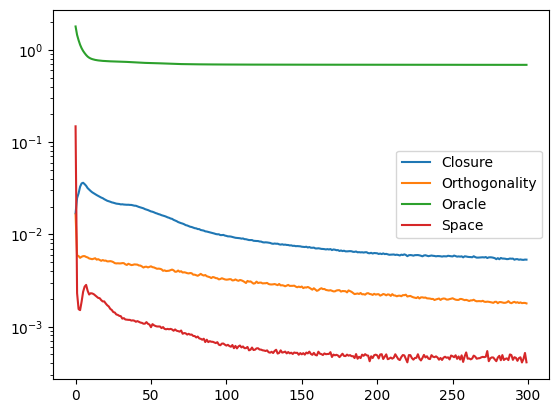

In [41]:
plt.plot(loss_S_closure, label =  "Closure")
plt.plot(loss_S_orth, label =  "Orthogonality")
plt.plot(loss_oracle, label =  "Oracle")
plt.plot(loss_space, label =  "Space")
plt.yscale("log")
plt.legend()

In [42]:
X, Y = next(iter(train_dataloader_Z))
X = X.to(device)
theta = 2*torch.ones(X.shape[0]) - 1 #Sampling
zero = torch.zeros(X.shape[0], device = device)
theta = theta.to(device)


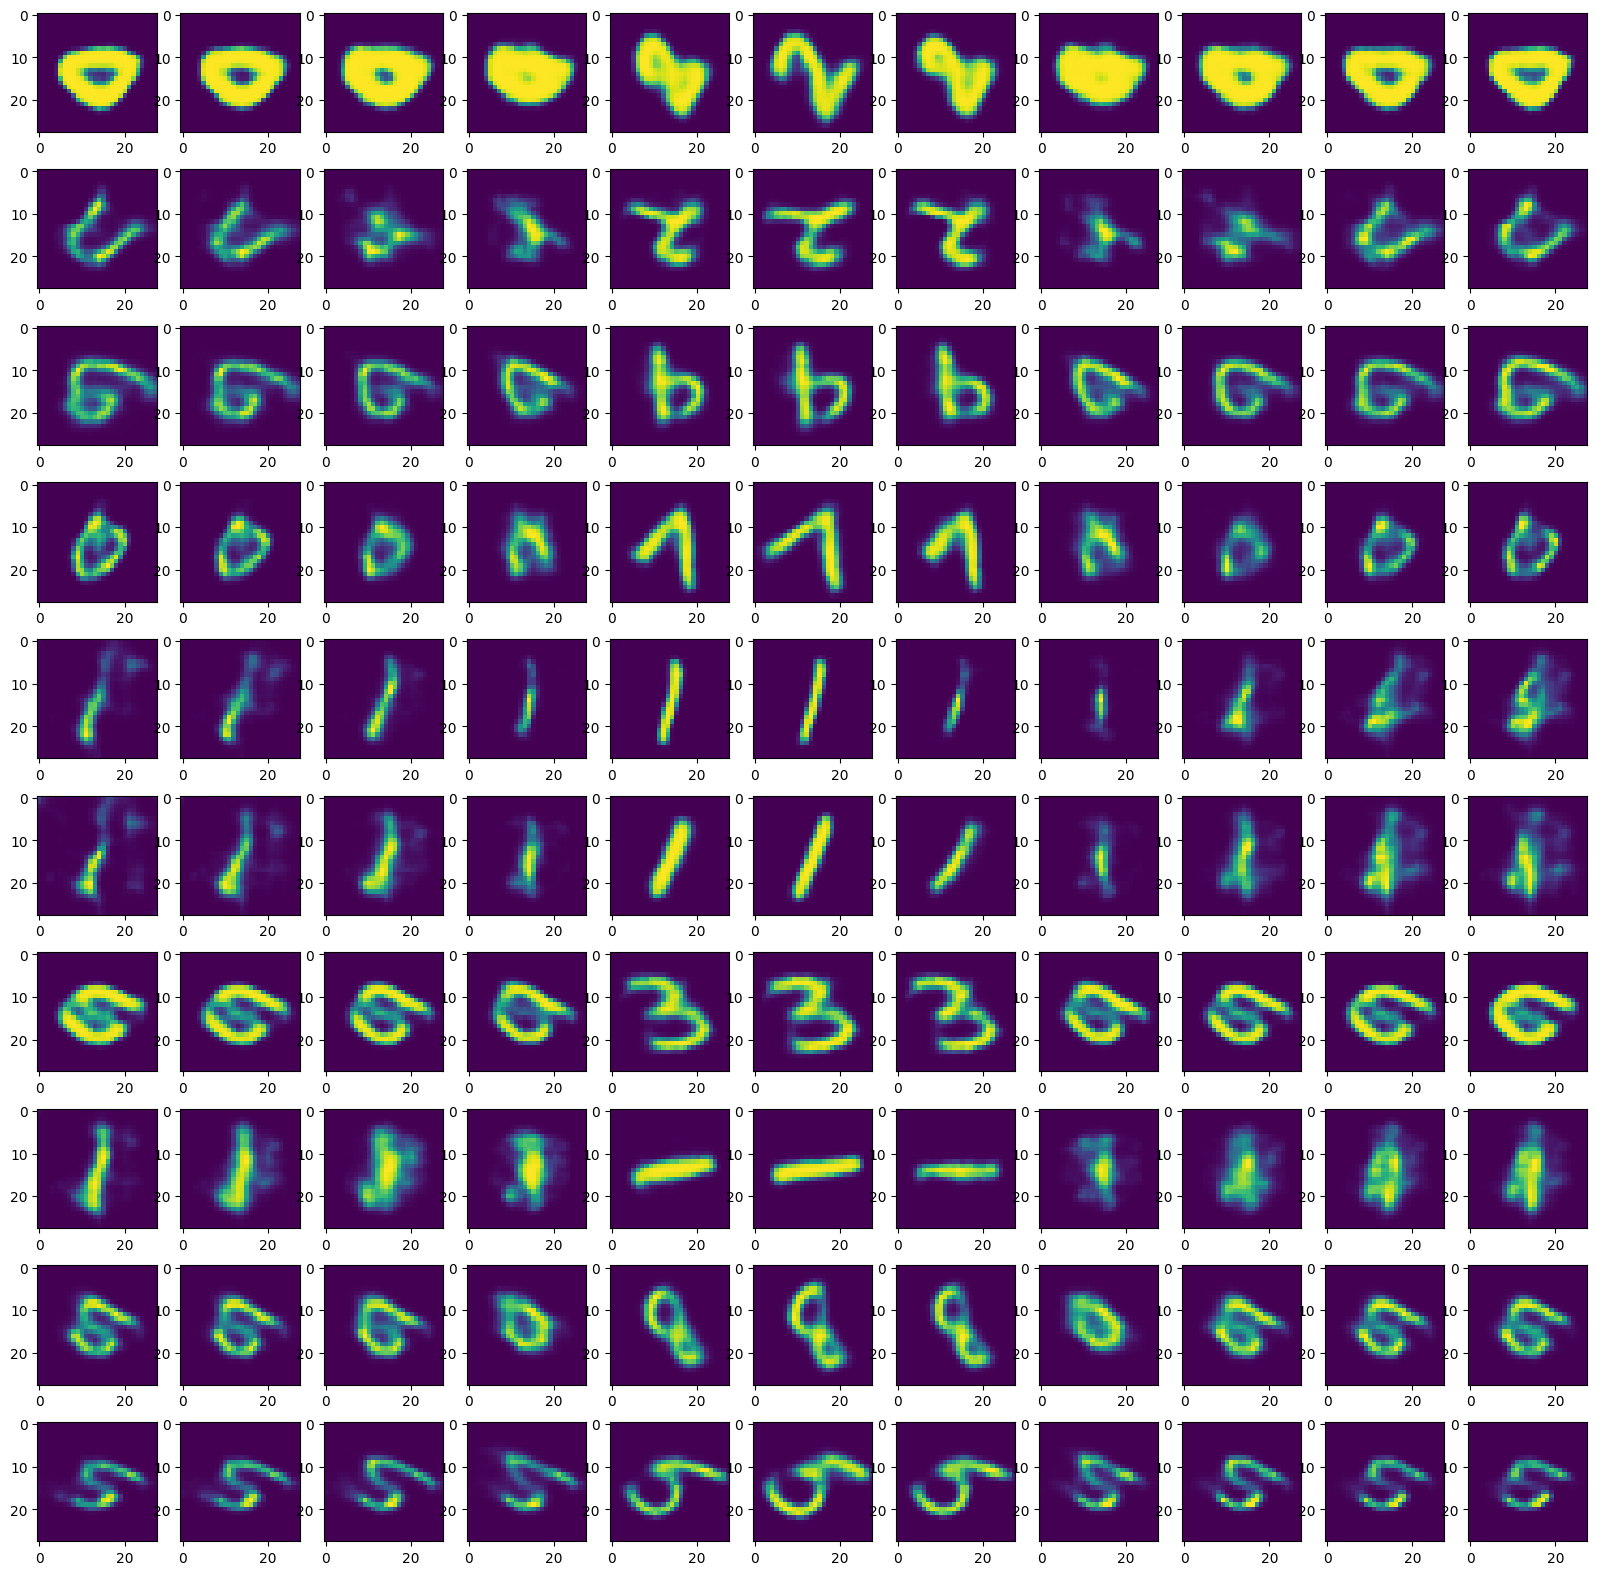

In [43]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([theta*(step),zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

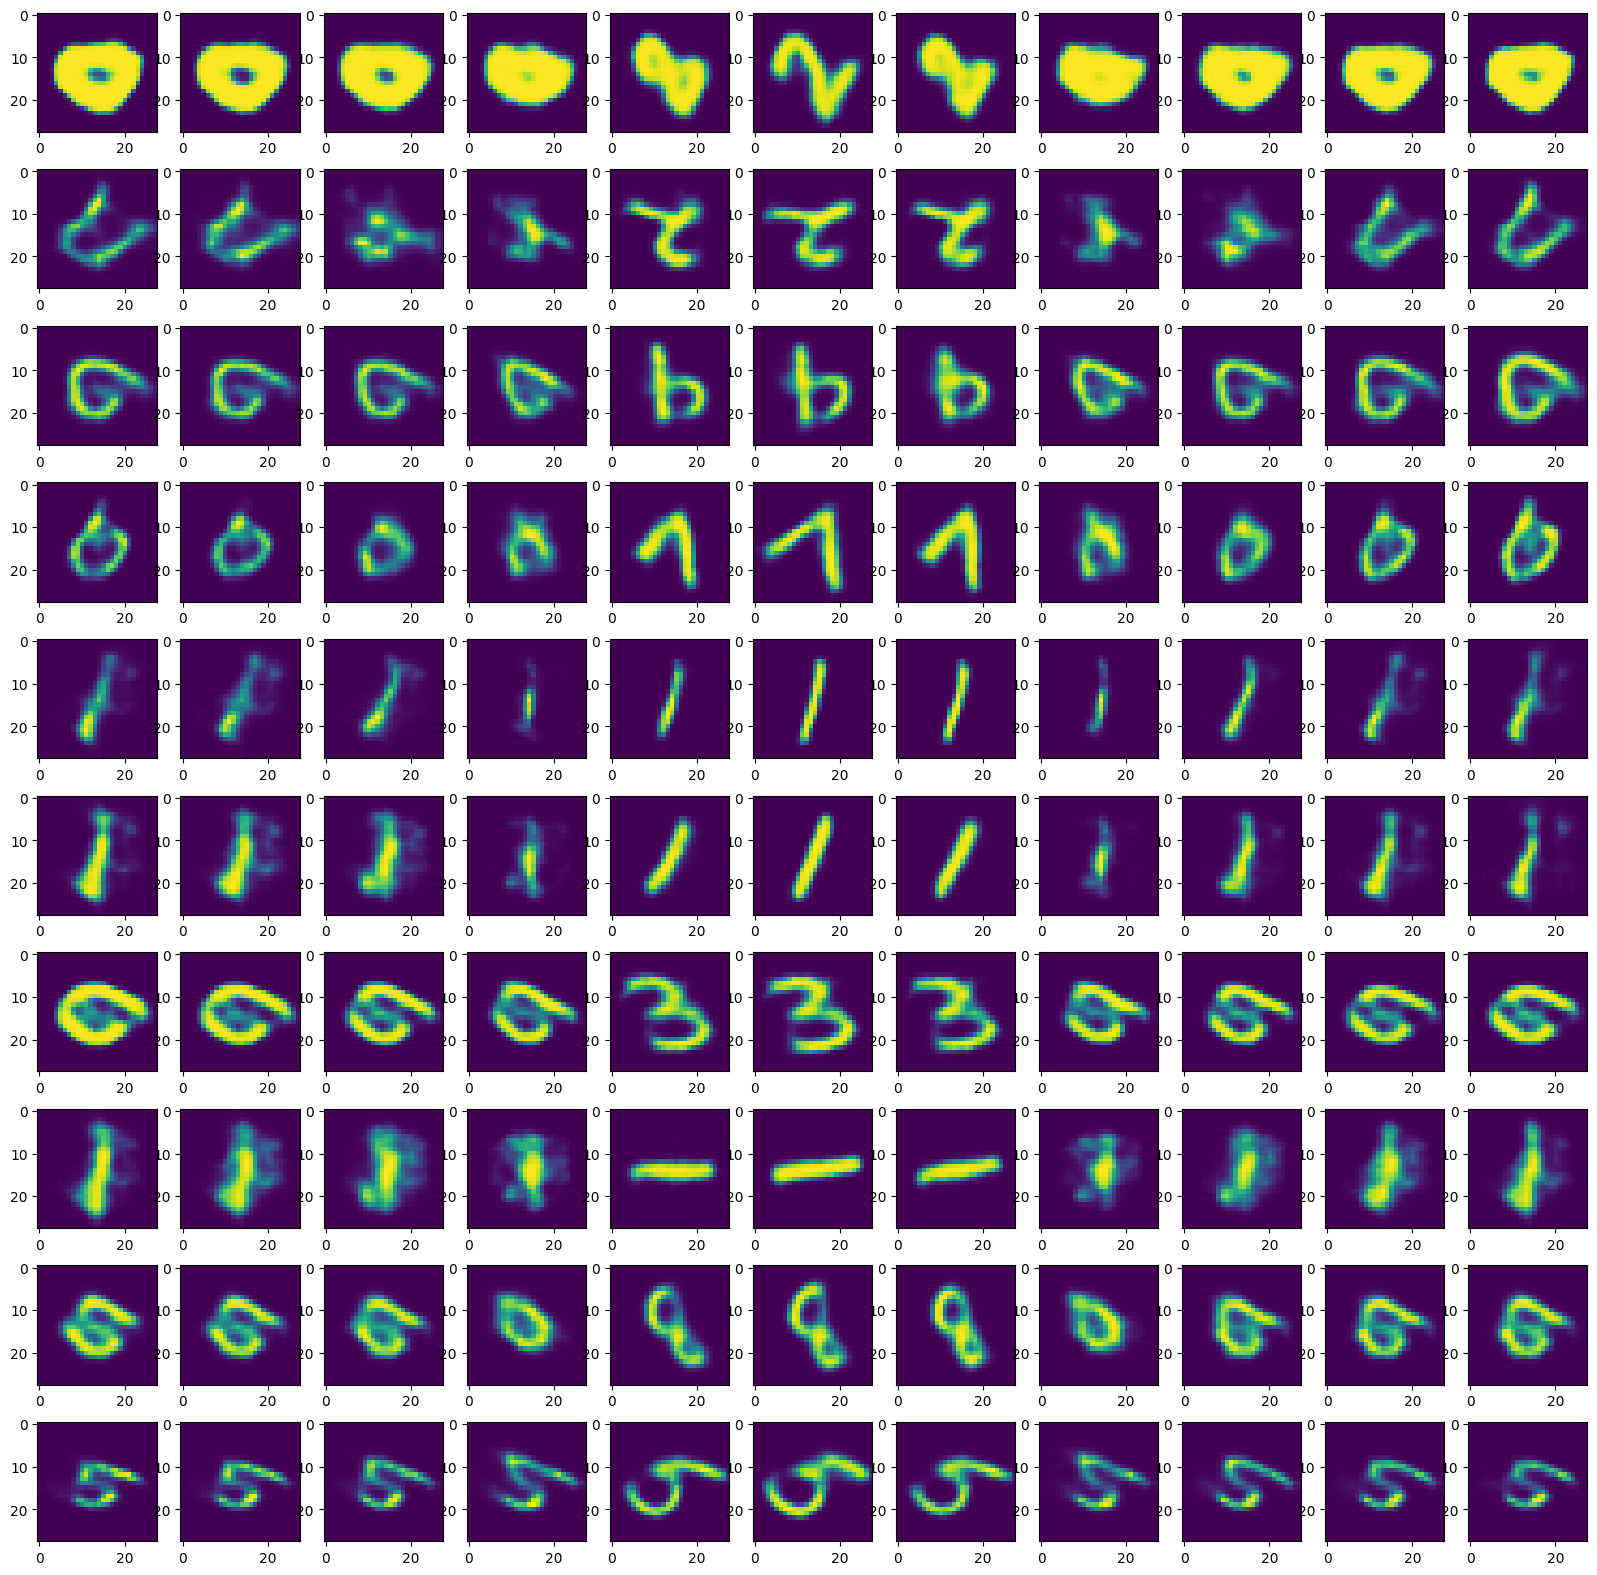

In [44]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,theta*(step),zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

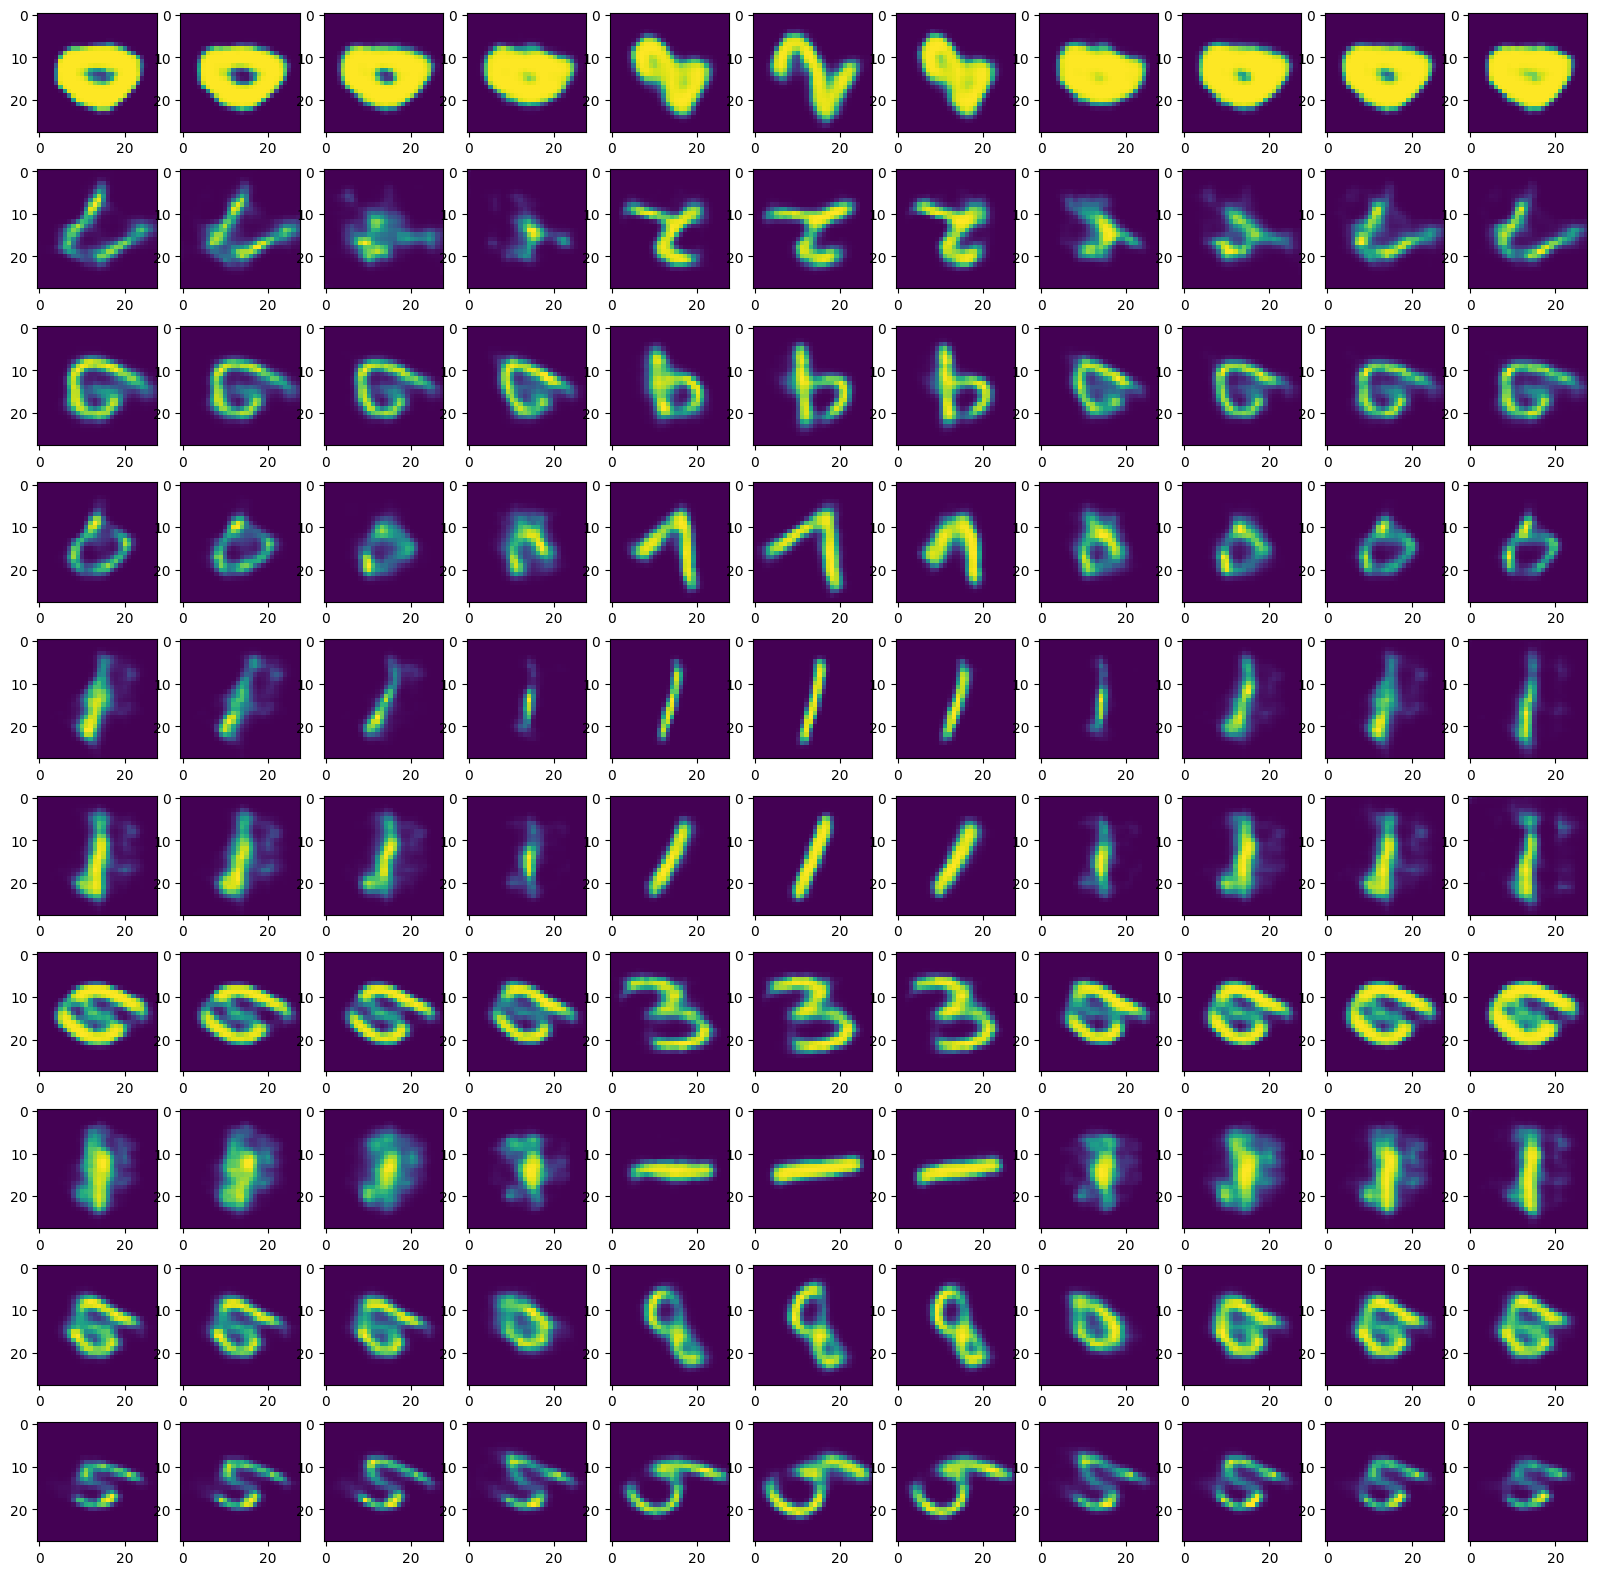

In [45]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,zero,theta*(step)],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

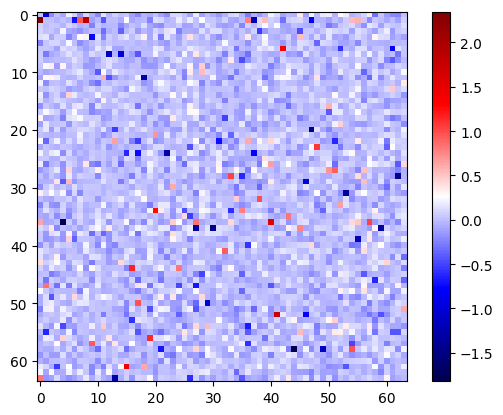

In [46]:
plt.imshow(model_symmetry.group[0].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

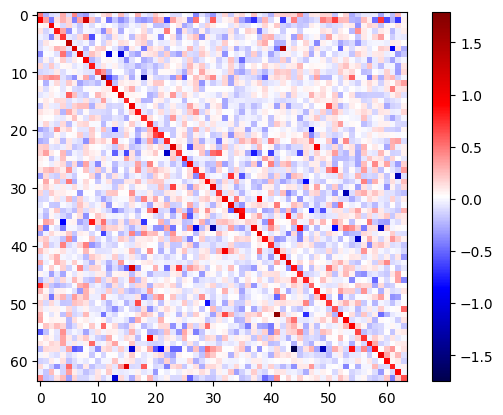

In [47]:
plt.imshow(torch.matrix_exp(model_symmetry.group[0].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

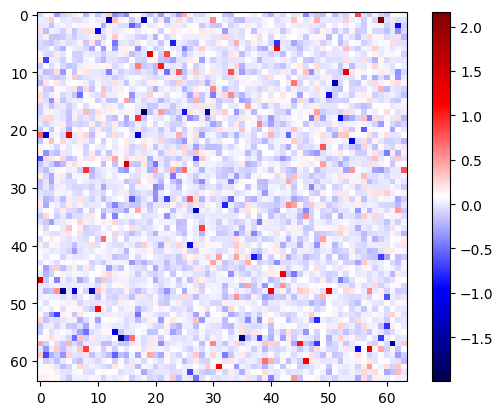

In [48]:
plt.imshow(model_symmetry.group[1].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

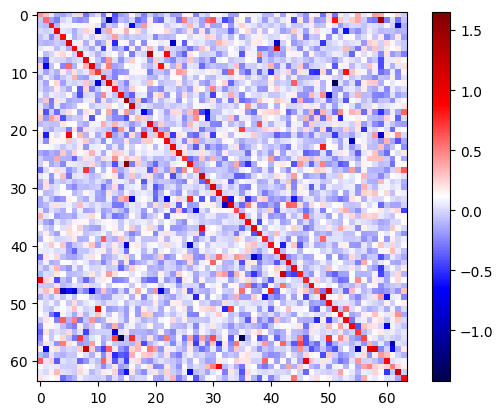

In [49]:
plt.imshow(torch.matrix_exp(model_symmetry.group[1].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

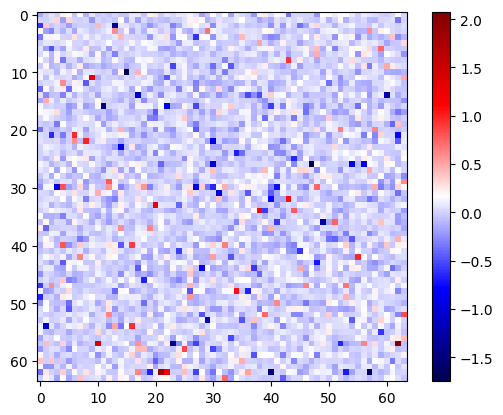

In [50]:
plt.imshow(model_symmetry.group[2].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

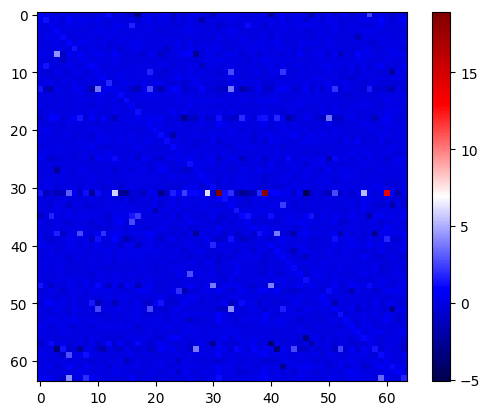

In [58]:
plt.imshow(torch.matrix_exp(model_symmetry.group[2].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()